In [1]:
from os import path
import pickle

import astropy.coordinates as coord
from astropy.table import Table
import astropy.units as u
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
#plt.style.use('apw-notebook')
%matplotlib inline
import sqlutil
from scipy.stats import binned_statistic_dd
from dustmaps.sfd import SFDQuery
from astropy.coordinates import SkyCoord
import astropy.units as units
import healpy as hp
import healpix_util as hu

from xdgmm import XDGMM

In [2]:
def queryDatabase(query, columns, post_query, cache_file='db.pickle'):

    #cache_file = "reducedPM2.pickle"

    if not path.exists(cache_file):
        res = sqlutil.get(query.format(','.join(columns), post_query),
                          db='wsdb', host='cappc127.ast.cam.ac.uk', 
                          user='gaia_sprint', password='NOT@Gaia_sprint', 
                          asDict=True)

        with open(cache_file, "wb") as f:
            pickle.dump(res, f)
        
    else:
        with open(cache_file, "rb") as f:
            res = pickle.load(f)
    return res

In [5]:
def plotPixels(x, y, pixel_array, mapSky, pixelImages, plotEach=False, 
               xlim=(-2, 2.5), ylim=(2, -1), vmin=0.01, vmax=10., 
               xlabel='log distance', ylabel='log proper motion', 
               fignameAll='pofd_allPixels.pdf', fignameEachpre='pofd', 
               bins=100, normed=False, norm=None, cmap='Greys', dynRange=100., grid=False):
    fig, axes = plt.subplots(4*nside, 3*nside, figsize=(7*nside, 7*nside))
    axes = axes.flatten()
    if plotEach: fignow, axesnow = plt.subplots(1, 2, figsize=(10, 5))
    #loop over pixel on sky
    for ax, pixel_index in zip(axes, range(np.max(pixel_array)+1)):
        axesnow[0].cla()
        axesnow[1].cla()
        index = pixel_array == pixel_index
        if np.sum(index):
            for axis in [ax, axesnow[0]]:
                counts, xedges, yedges = np.histogram2d(x[index], y[index], bins=bins, normed=normed)
                if norm == 'lognorm': 
                    minhist = np.min(counts[counts > 0])
                    norm=mpl.colors.LogNorm(vmin=minhist, vmax=minhist*dynRange)
                axis.imshow(counts, origin='lower', extent=[np.min(xedges), np.max(xedges), np.min(yedges), np.max(yedges)], cmap=cmap, norm=norm)
                axis.set_xlim(xlim)
                axis.set_ylim(ylim)
                axis.set_xlabel(xlabel)
                axis.set_ylabel(ylabel)
                axis.grid()
            axesnow[1].imshow(mapSky, origin='lower', extent=[-180, 180, -90, 90])
            axesnow[1].imshow(pixelImages[pixel_index], origin='lower', cmap='Greys', alpha=0.3, extent=[-180, 180, -90, 90])
            axesnow[1].set_xlabel('l')
            axesnow[1].set_ylabel('b')
            fignow.savefig('{0}_{1:03d}.pdf'.format(fignameEachpre, pixel_index), rasterized=True)
    fig.savefig(fignameAll)
    plt.close(fig)
    plt.close(fignow)

In [6]:
columns = '*'
query = "Select {0} FROM gaia_dr1.gaia_source {1}"
cuts = 'LIMIT 10'
res = queryDatabase(query, columns, cuts, cache_file='gaiaListColumns')
tbl = Table(res)
tbl.keys()

['solution_id',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_good_obs_ac',
 'astrometric_n_bad_obs_al',
 'astrometric_n_bad_obs_ac',
 'astrometric_delta_q',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_primary_flag',
 'astrometric_relegation_factor',
 'astrometric_weight_al',
 'astrometric_weight_ac',
 'astrometric_priors_used',
 'matched_observations',
 'duplicated_source',
 'scan_direction_strength_k1',
 'scan_direction_strength_k2',
 'scan_direction_strength_k3',
 'scan_direction_strength_k4',
 'scan_direction_mean_k1',
 'scan_direction_mean_

In [7]:
columns = '*'
query = "Select {0} FROM gaia_dr1_aux.gaia_source_sdssdr9_xm_new {1}"
cuts = "LIMIT 10"
res = queryDatabase(query, columns, cuts, cache_file='sdssListColumns')
tbl = Table(res)
tbl.keys()
#print tbl['ra'], tbl['dec']

['solution_id',
 'source_id',
 'random_index',
 'ref_epoch',
 'ra',
 'ra_error',
 'dec',
 'dec_error',
 'parallax',
 'parallax_error',
 'pmra',
 'pmra_error',
 'pmdec',
 'pmdec_error',
 'ra_dec_corr',
 'ra_parallax_corr',
 'ra_pmra_corr',
 'ra_pmdec_corr',
 'dec_parallax_corr',
 'dec_pmra_corr',
 'dec_pmdec_corr',
 'parallax_pmra_corr',
 'parallax_pmdec_corr',
 'pmra_pmdec_corr',
 'astrometric_n_obs_al',
 'astrometric_n_obs_ac',
 'astrometric_n_good_obs_al',
 'astrometric_n_good_obs_ac',
 'astrometric_n_bad_obs_al',
 'astrometric_n_bad_obs_ac',
 'astrometric_delta_q',
 'astrometric_excess_noise',
 'astrometric_excess_noise_sig',
 'astrometric_primary_flag',
 'astrometric_relegation_factor',
 'astrometric_weight_al',
 'astrometric_weight_ac',
 'astrometric_priors_used',
 'matched_observations',
 'duplicated_source',
 'scan_direction_strength_k1',
 'scan_direction_strength_k2',
 'scan_direction_strength_k3',
 'scan_direction_strength_k4',
 'scan_direction_mean_k1',
 'scan_direction_mean_

In [8]:
sdsscolumns = [
    'random_index', 'source_id', 'ra', 'dec', 'l', 'b', 
    'pmra_new', 'pmdec_new', 'gs_pmra', 'gs_pmdec', 'extinction_u', 
    'extinction_g', 'extinction_r', 'extinction_i', 'extinction_z',
    'psfmag_u', 'psfmag_g', 'psfmag_r', 'psfmag_i', 'psfmag_z', 
    'psfmagerr_u', 'psfmagerr_g', 'psfmagerr_r', 'psfmagerr_i', 'psfmagerr_z', 
    'phot_g_mean_mag', 'ra_error', 'dec_error']
query = "Select {0} FROM gaia_dr1_aux.gaia_source_sdssdr9_xm_new {1}"
cuts = """WHERE abs(b) > 30 AND
                psfmag_r < 20 AND
                psfmag_r > 16 AND 
                mode = 1"""
res = queryDatabase(query, sdsscolumns, cuts, cache_file='gaiasdssHaloNew.pkl')
sdsstbl = Table(res)

In [17]:
pm = np.sqrt(sdsstbl['pmra_new']**2. + sdsstbl['pmdec_new']**2.)

/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:5: RuntimeWarning: divide by zero encountered in log10


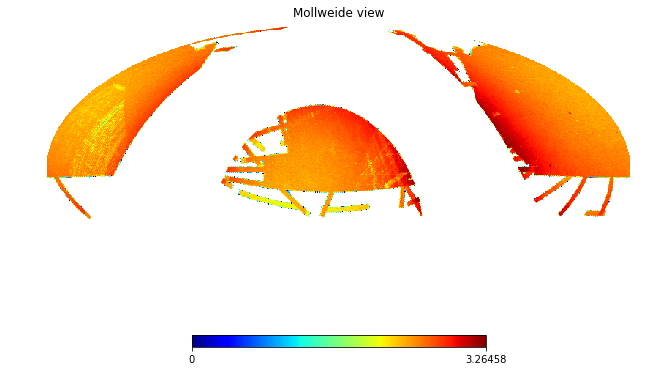

In [10]:
nside = 128
hpixMap = hu.HealPix("ring", nside)
pixnums = hpixMap.eq2pix(sdsstbl['ra'], sdsstbl['dec'])
omap = np.bincount(pixnums, minlength=hpixMap.npix)
mapSky = hp.mollview(np.log10(omap), return_projected_map=True)
plt.savefig('pofd_allsky.pdf')

In [20]:
nside = 4
hpix=hu.HealPix("ring", nside)
pixnums = hpix.eq2pix(sdsstbl[''][good], sdsstbl['b'][good])

//anaconda/lib/python2.7/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


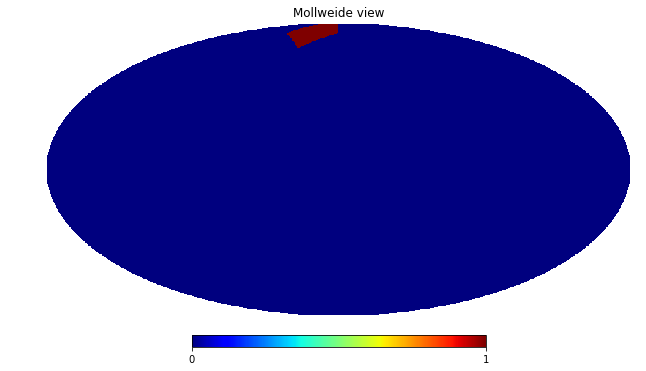

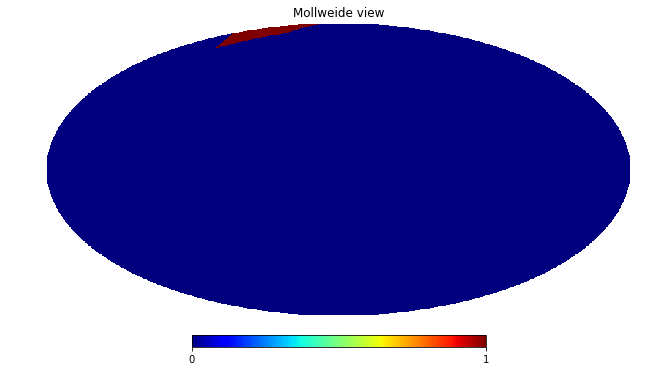

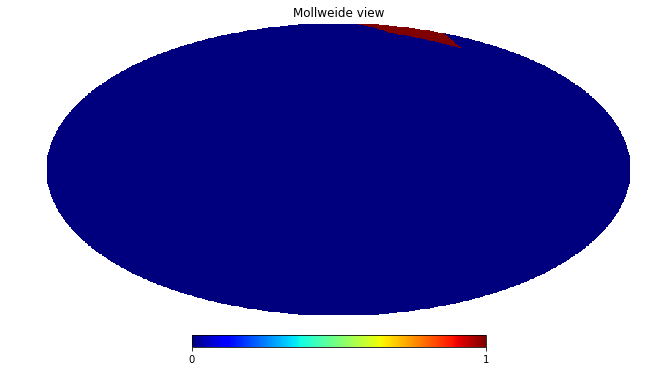

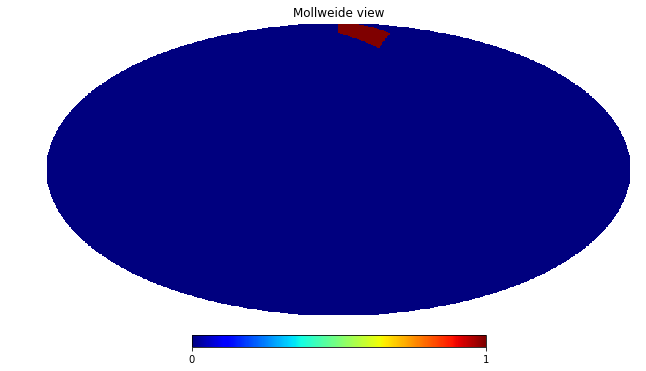

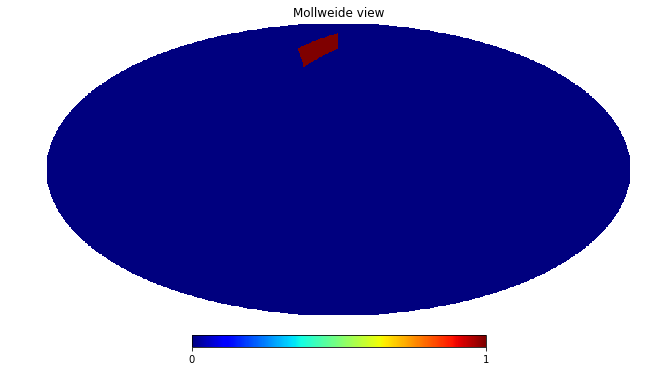

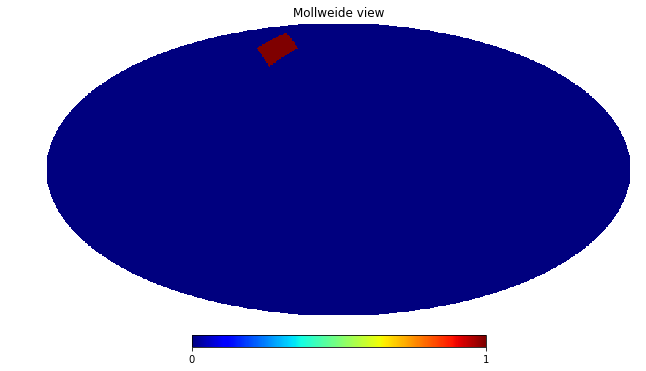

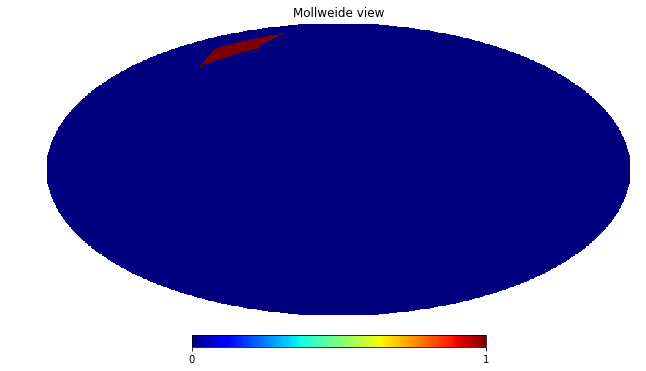

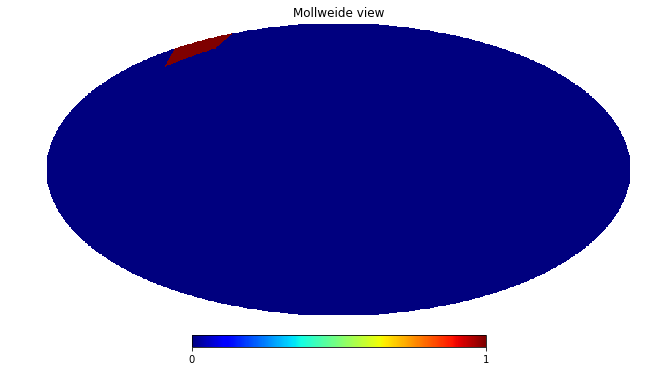

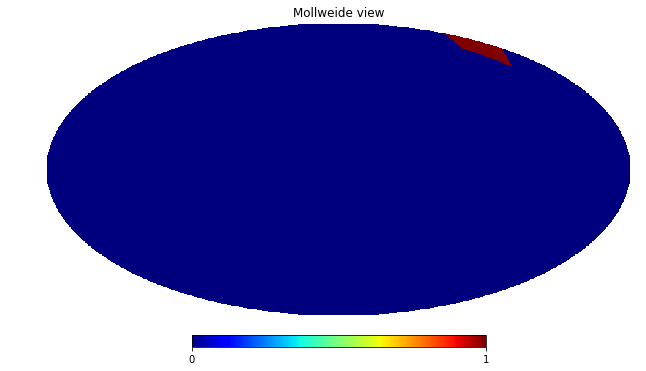

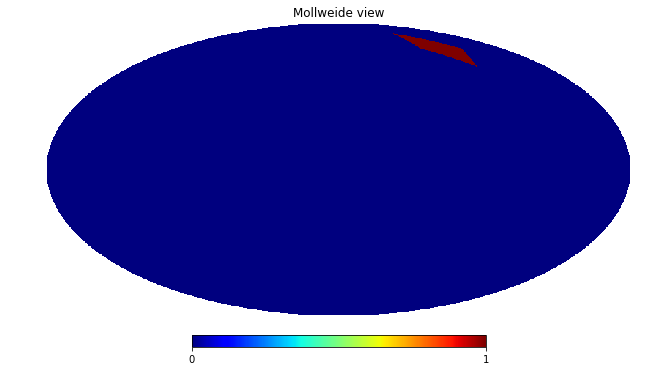

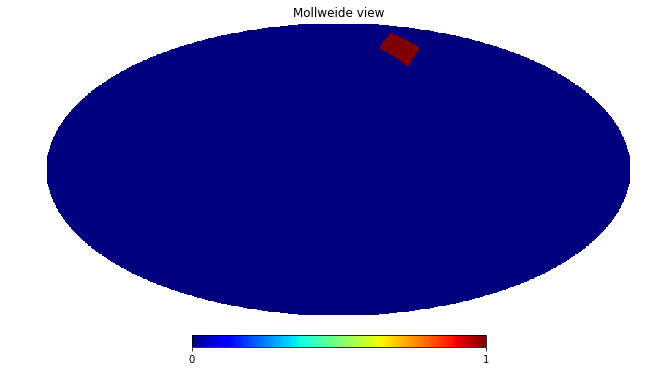

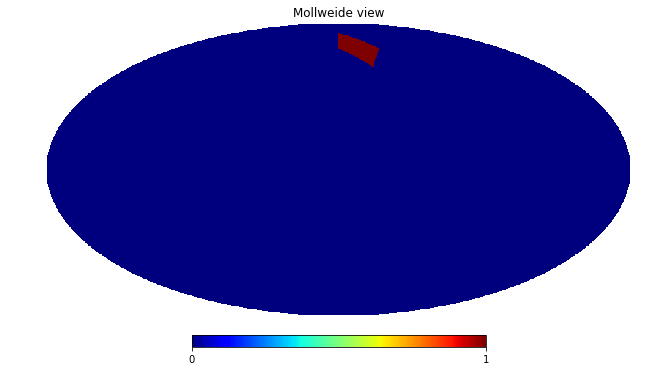

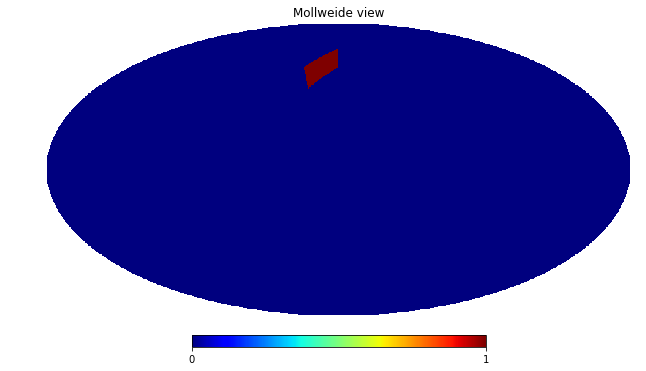

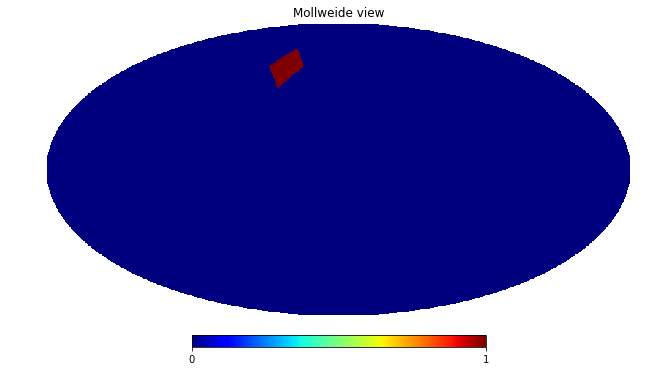

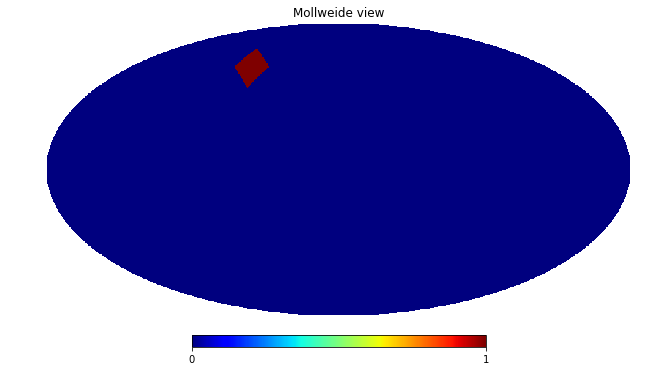

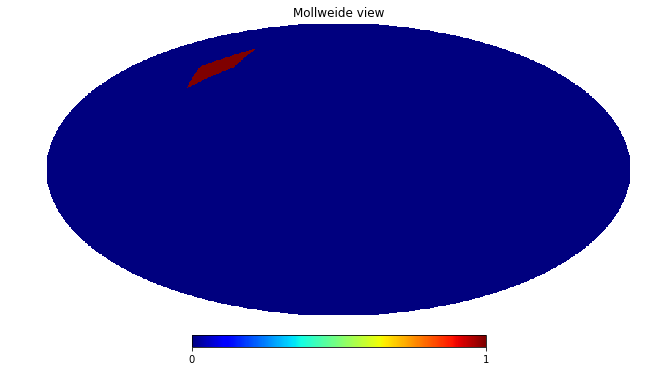

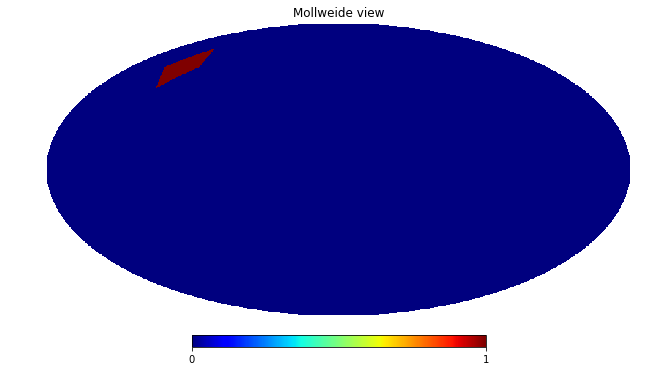

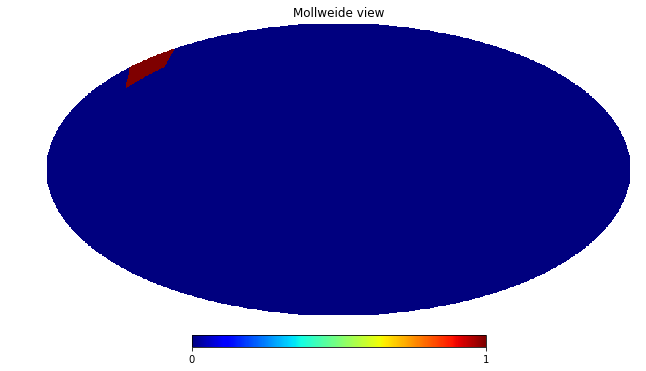

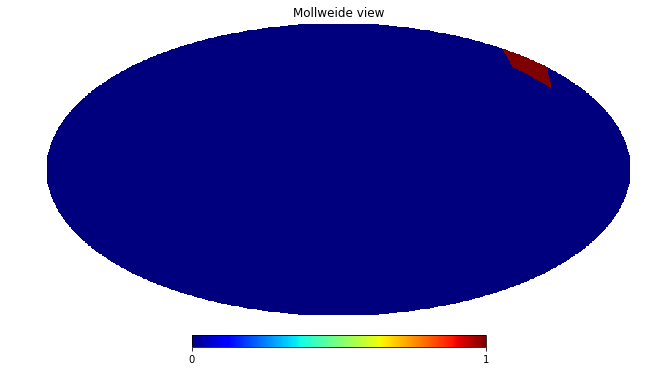

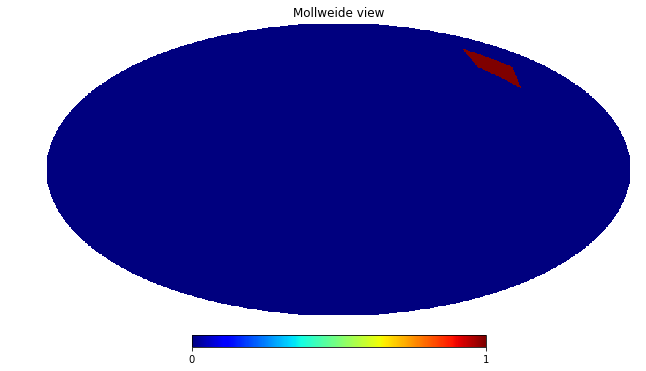

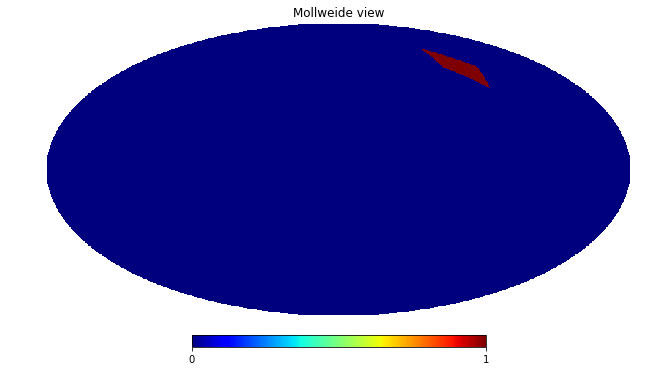

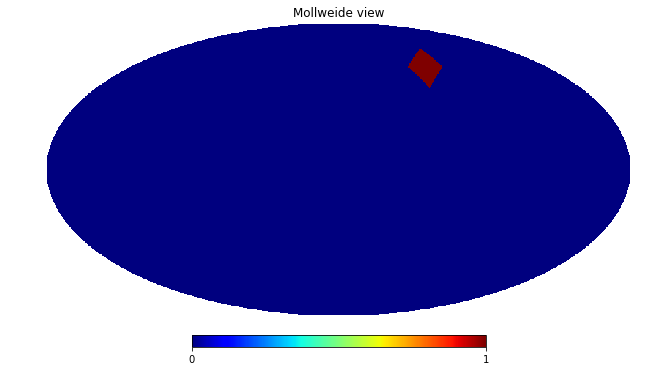

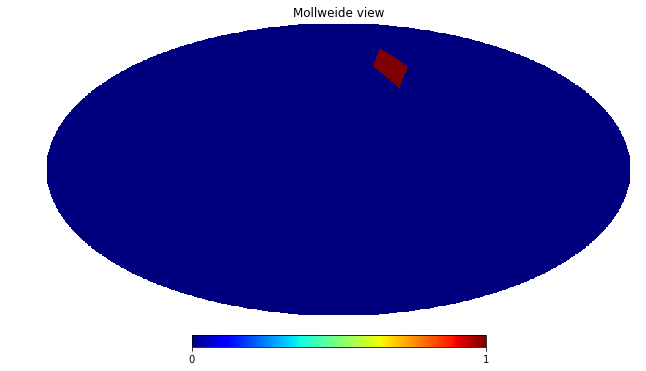

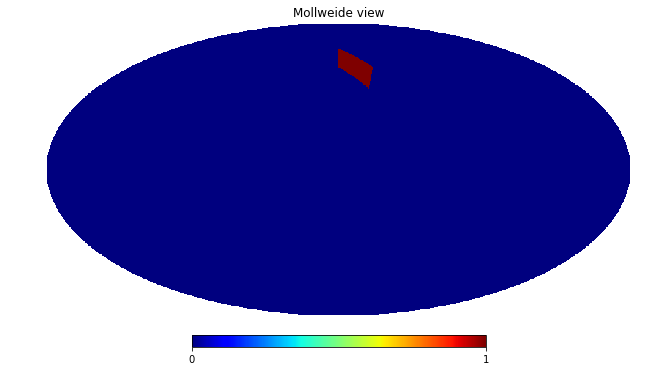

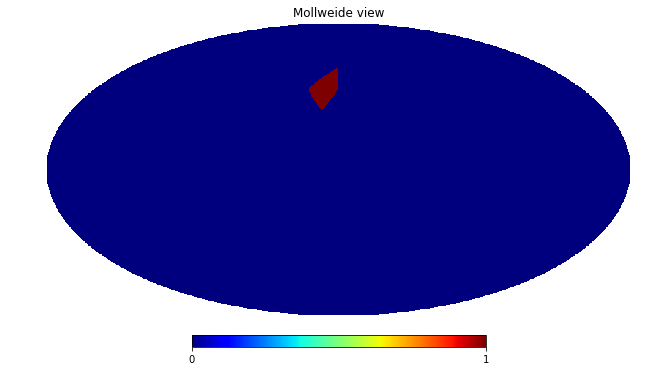

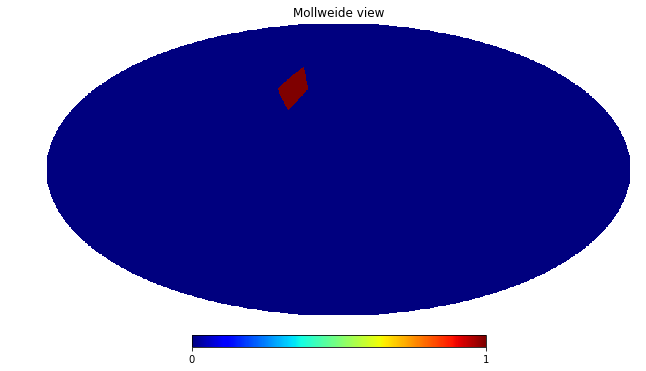

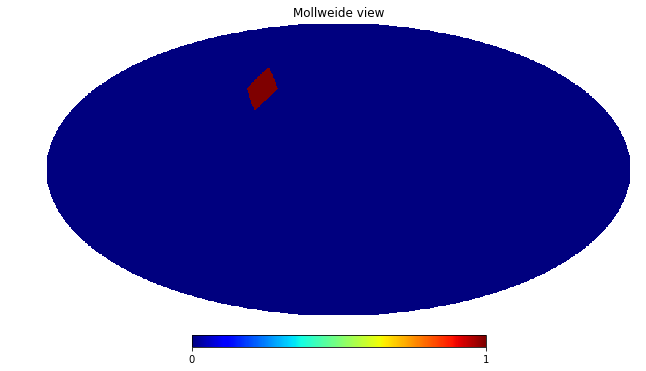

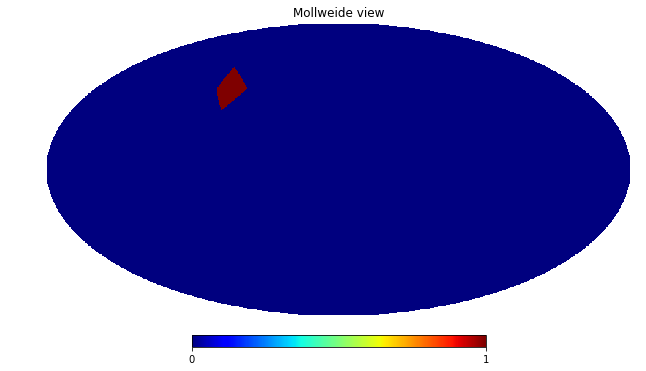

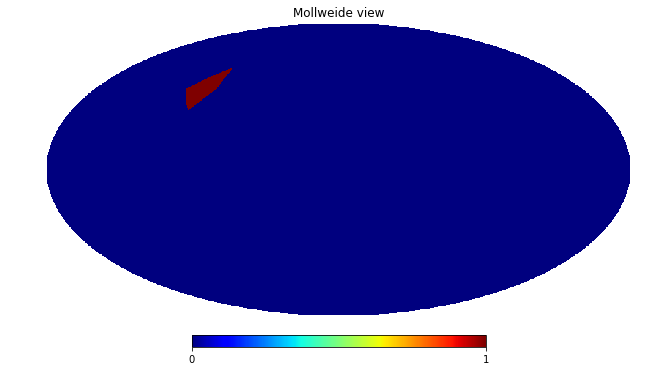

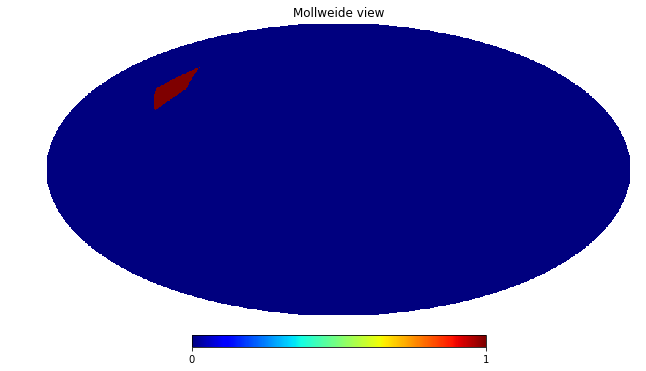

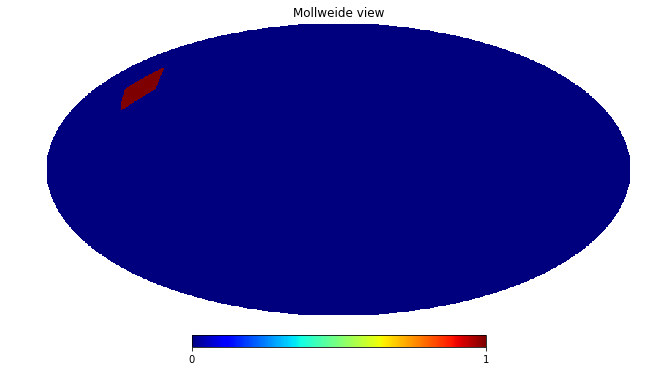

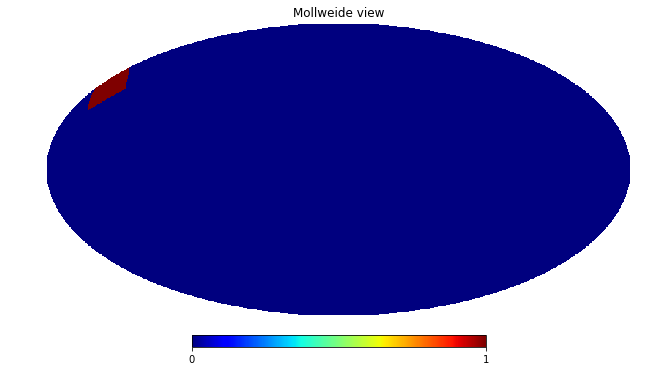

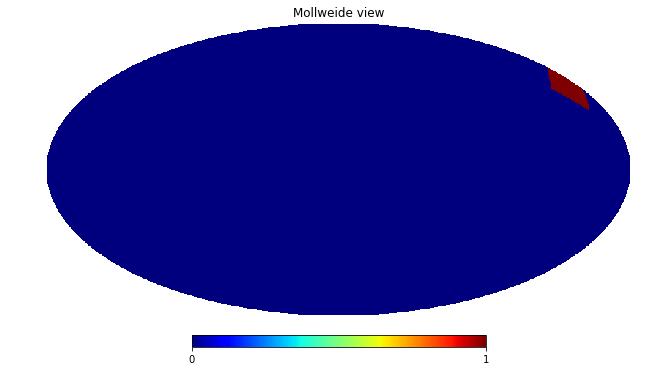

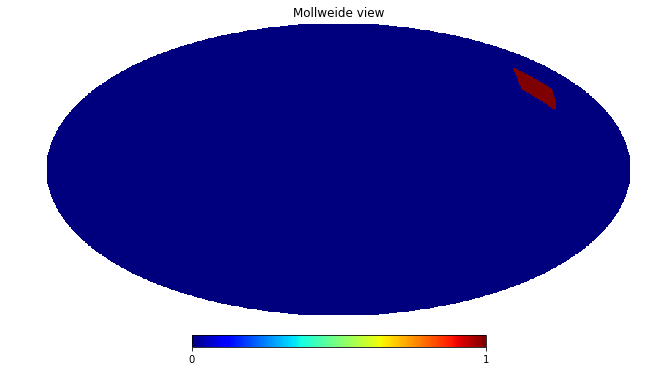

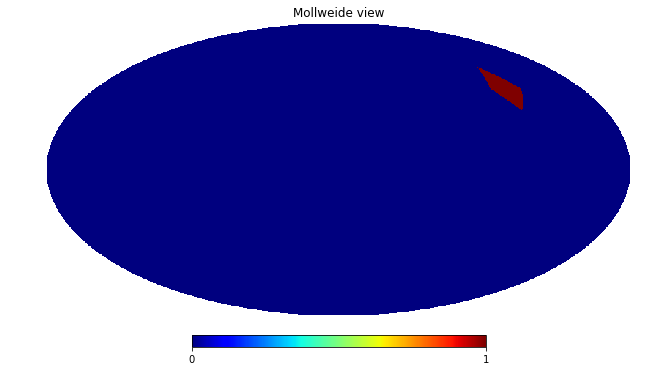

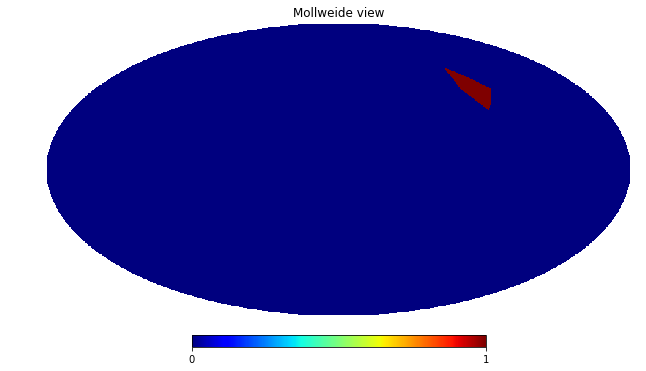

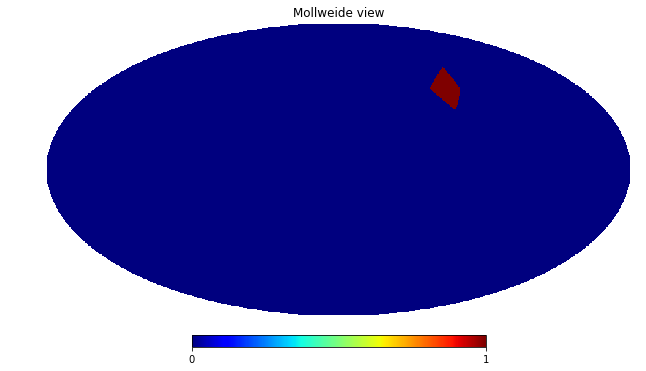

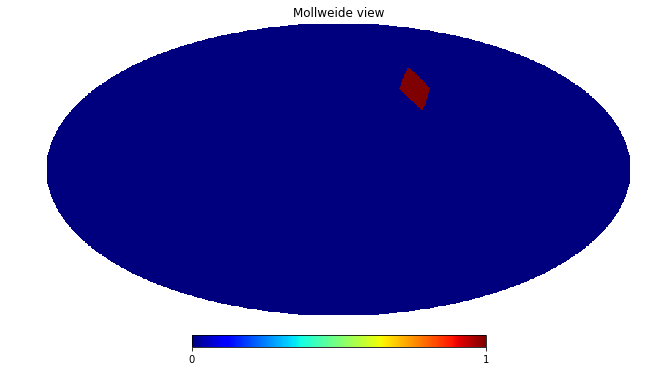

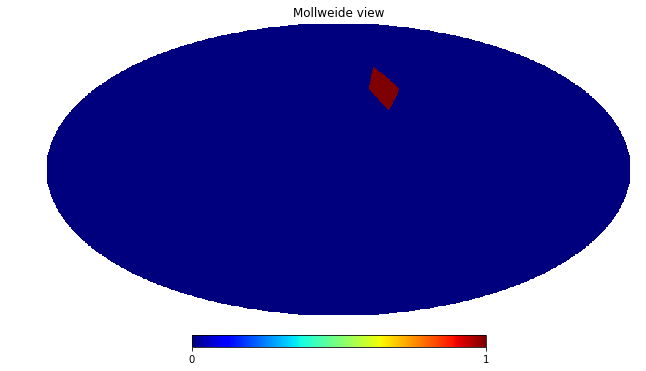

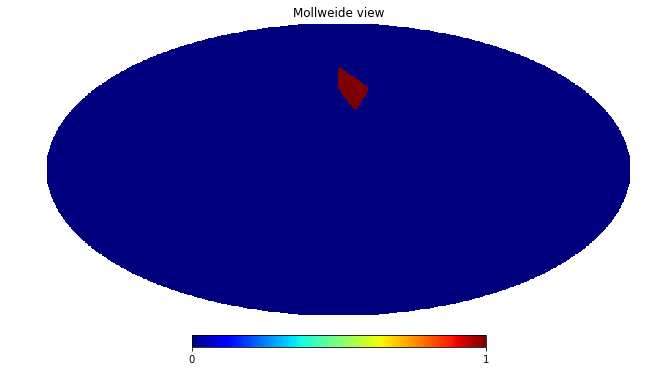

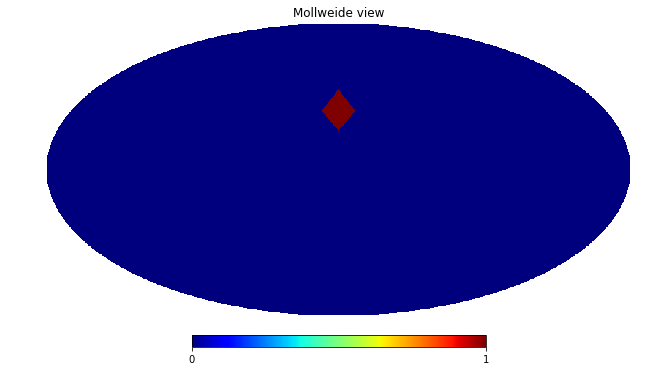

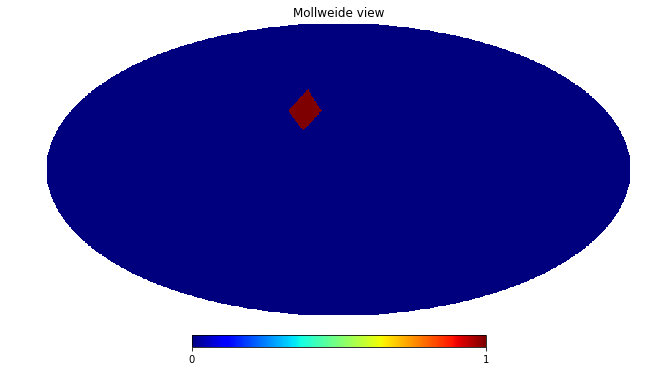

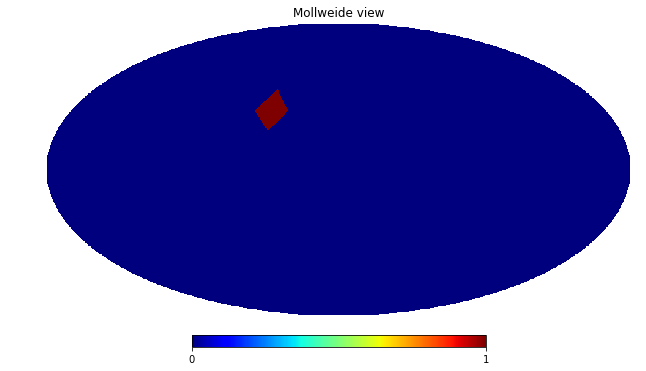

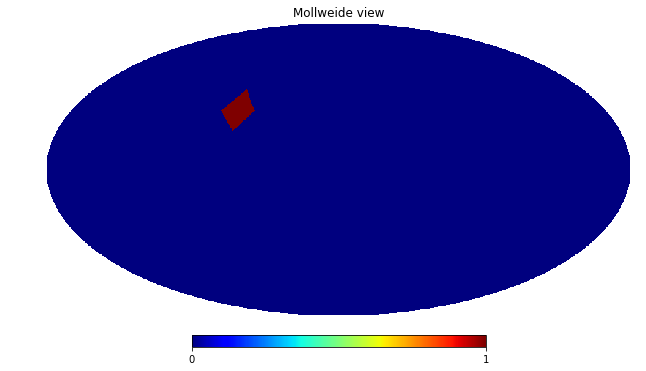

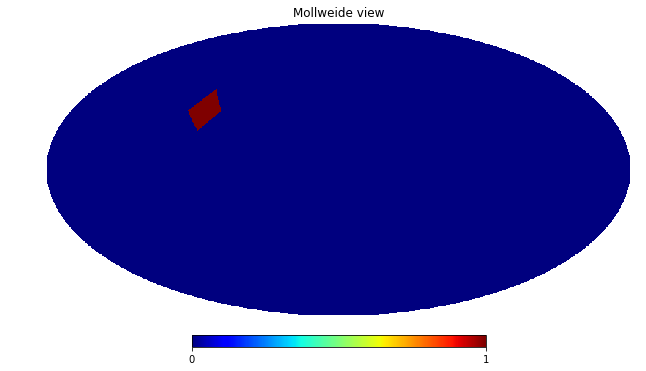

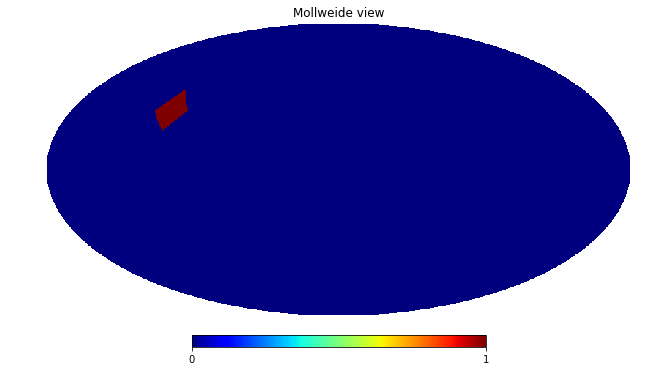

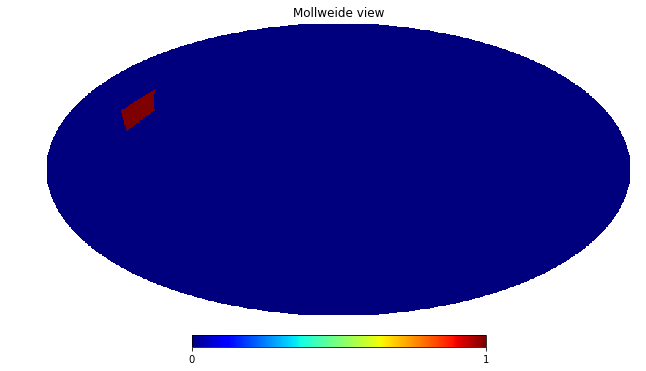

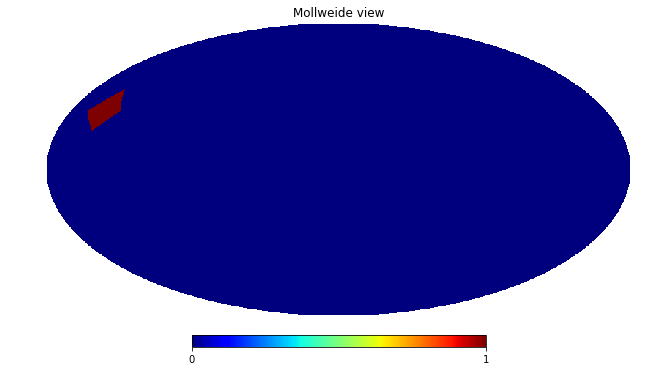

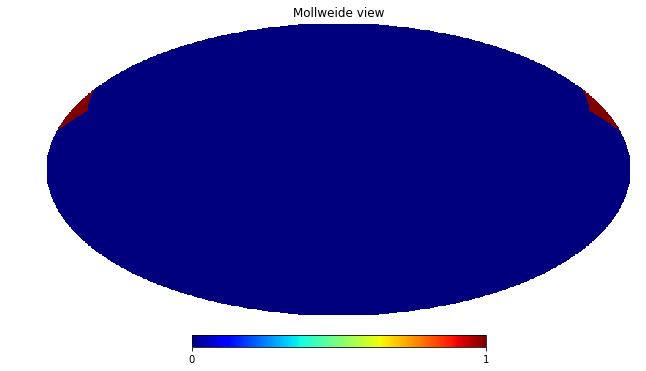

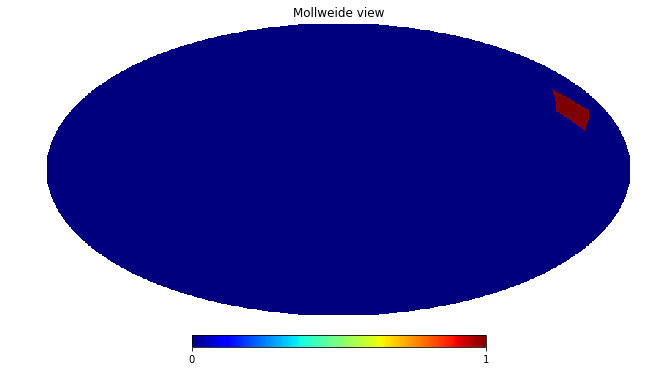

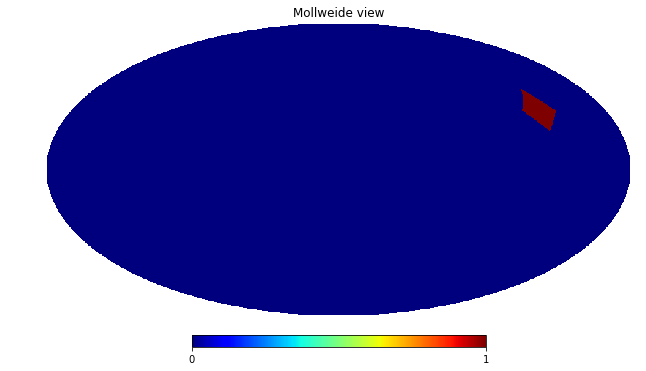

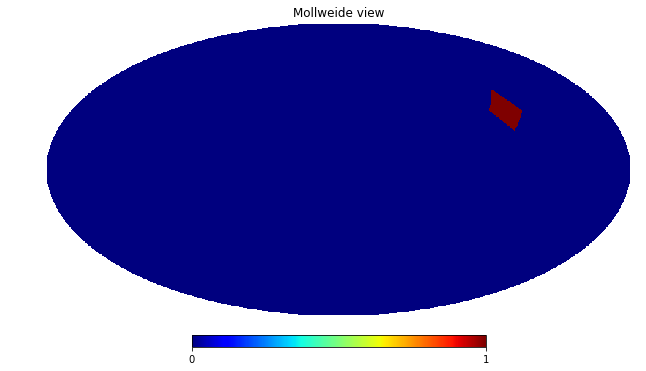

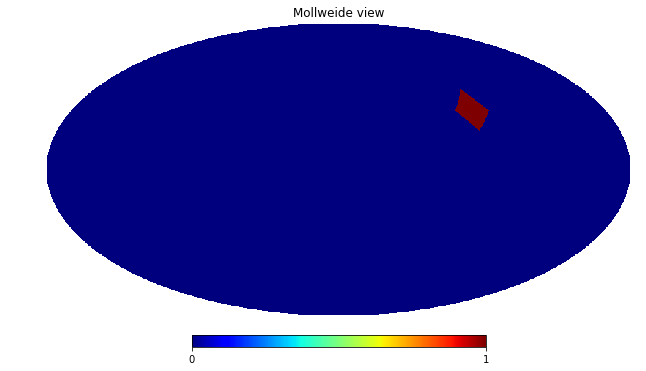

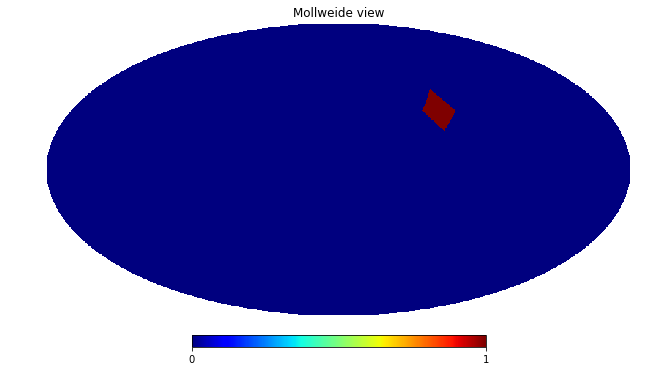

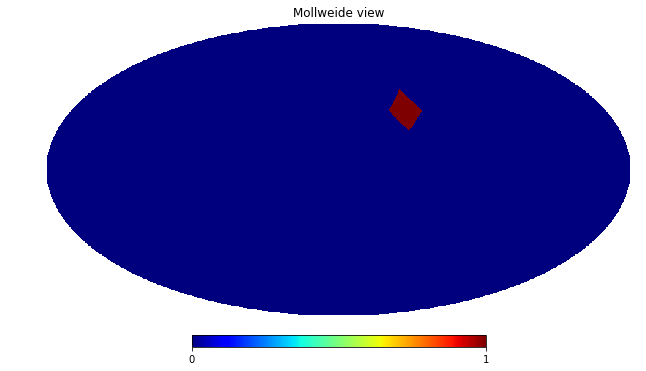

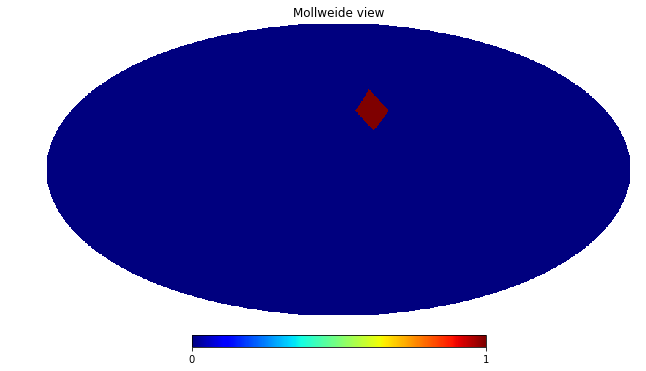

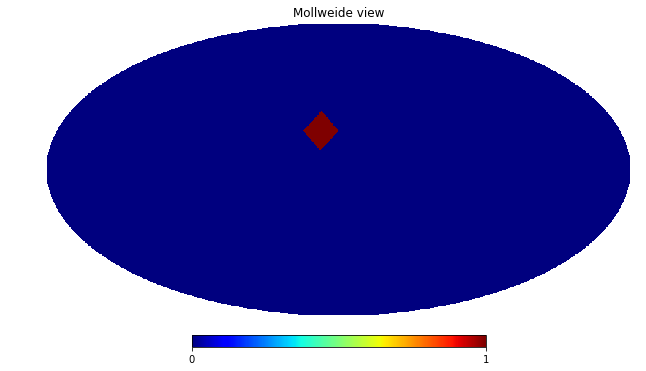

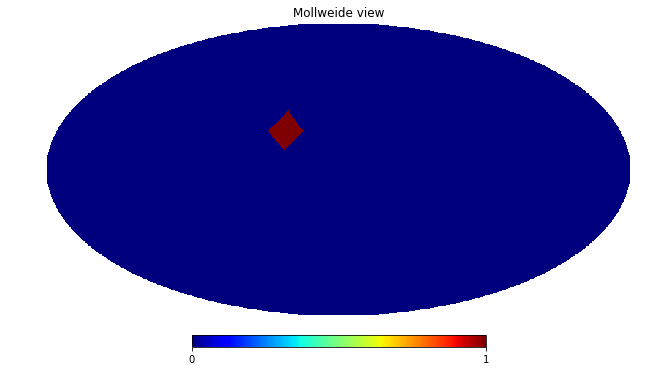

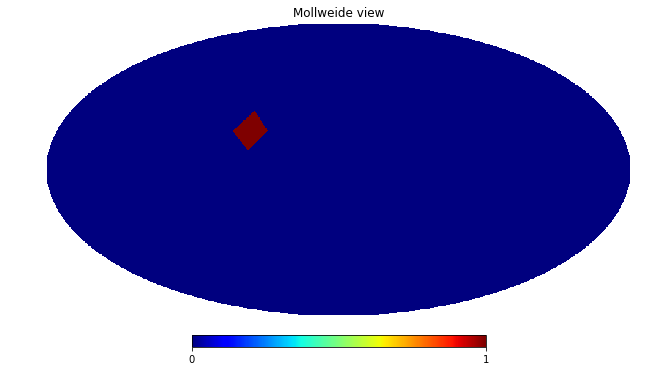

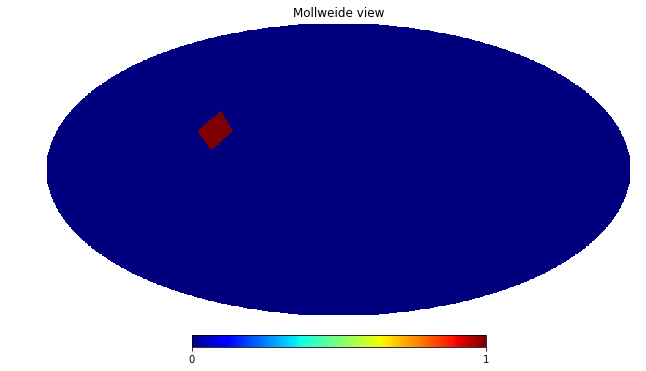

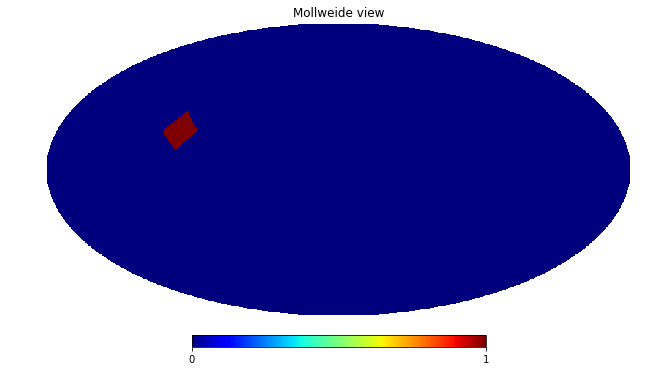

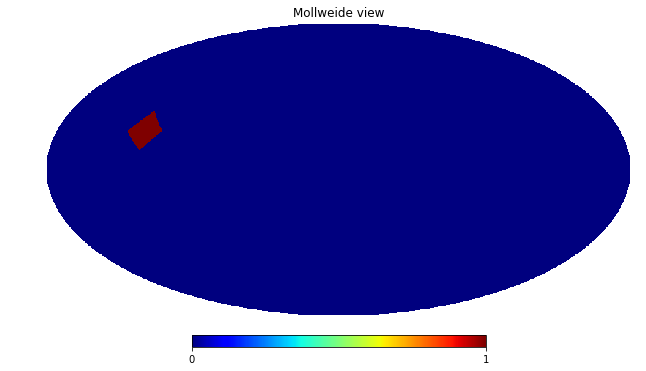

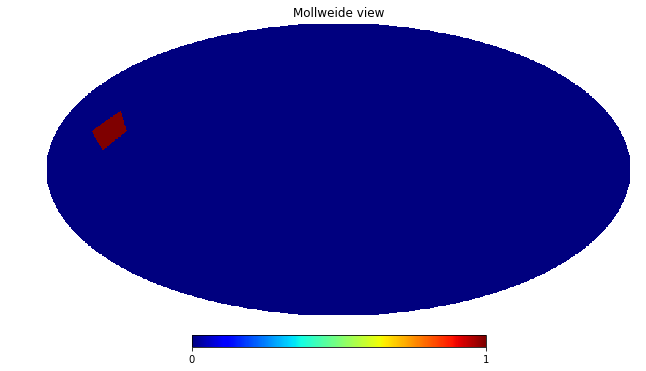

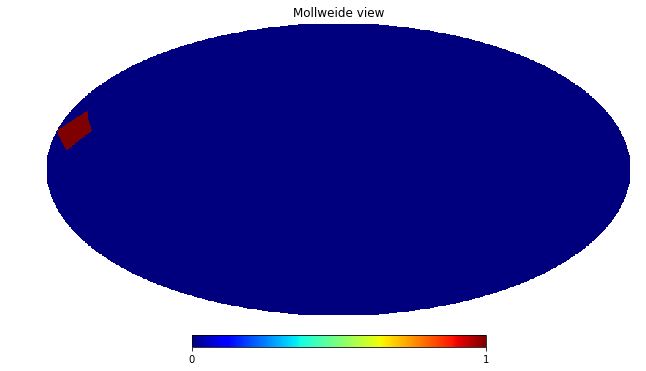

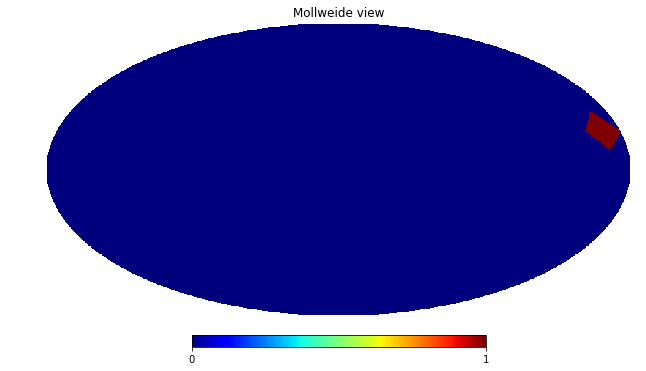

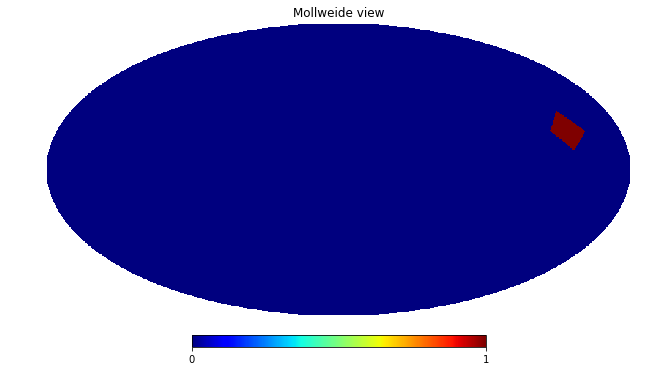

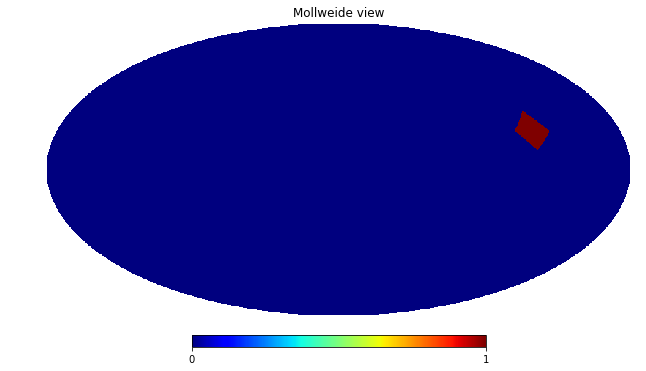

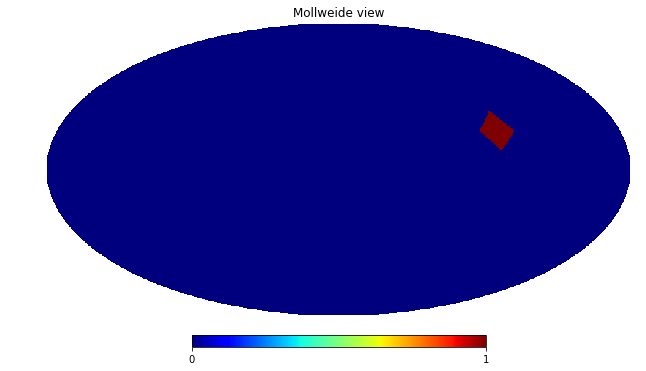

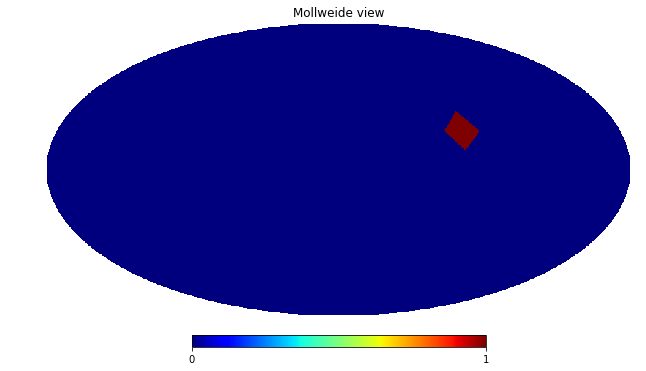

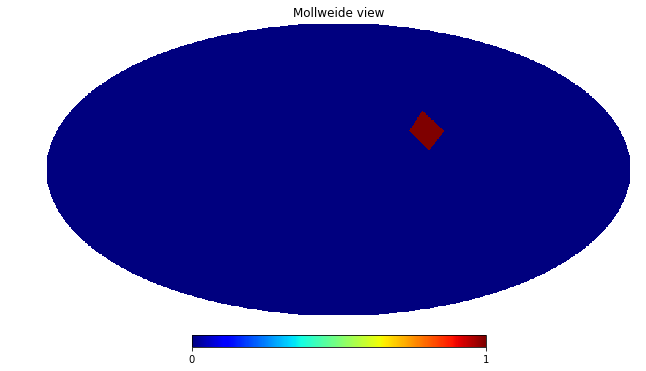

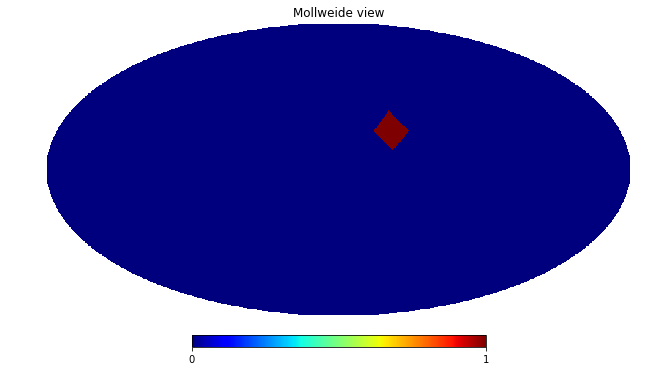

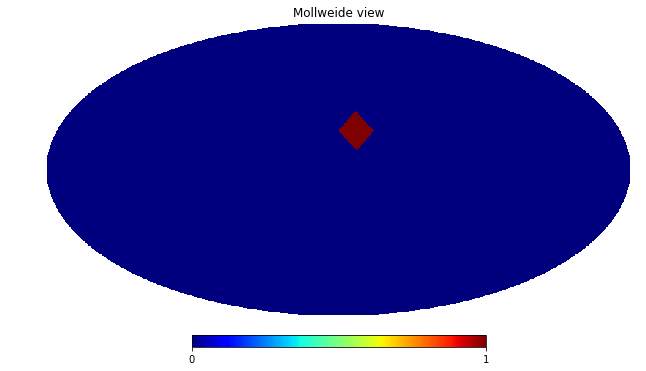

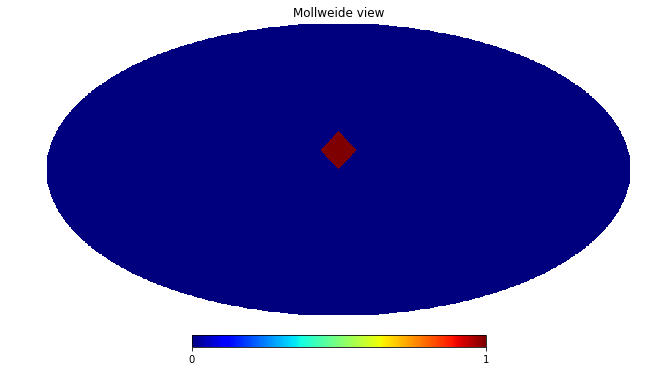

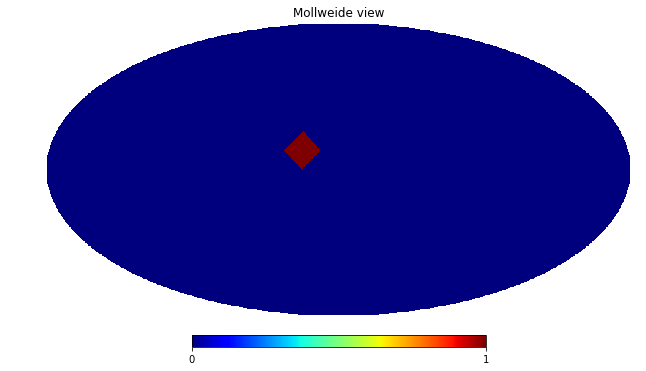

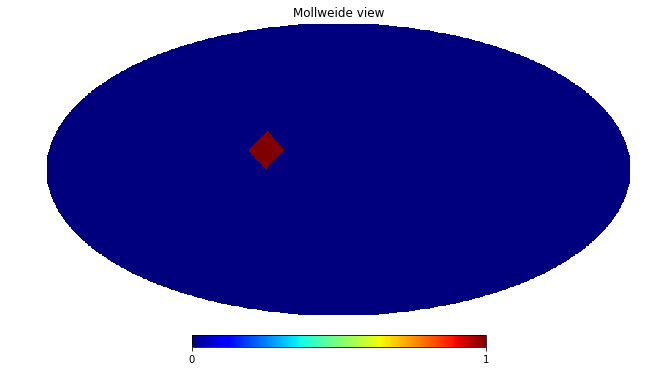

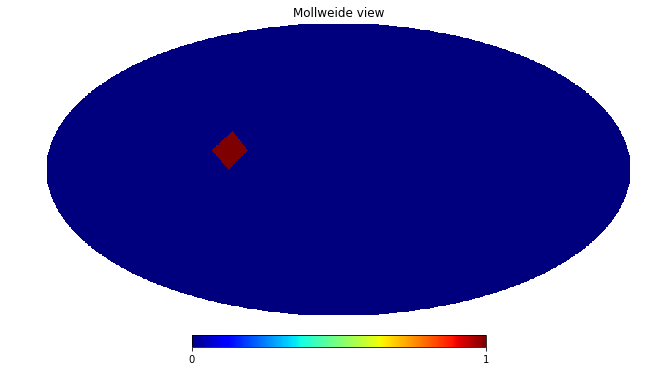

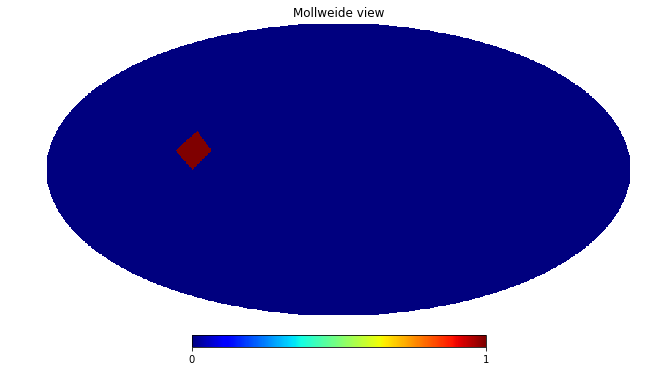

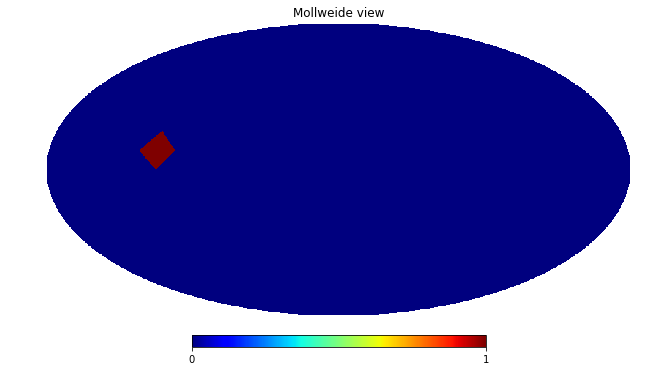

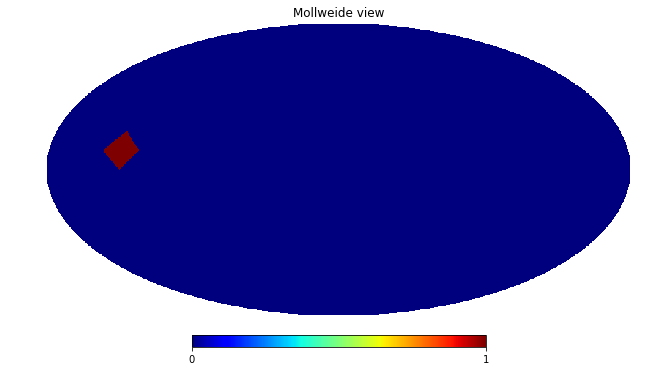

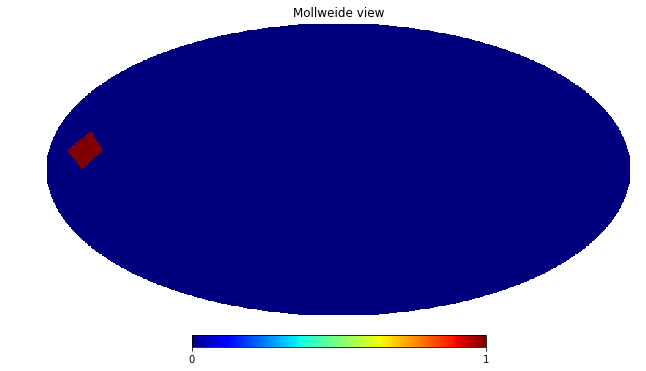

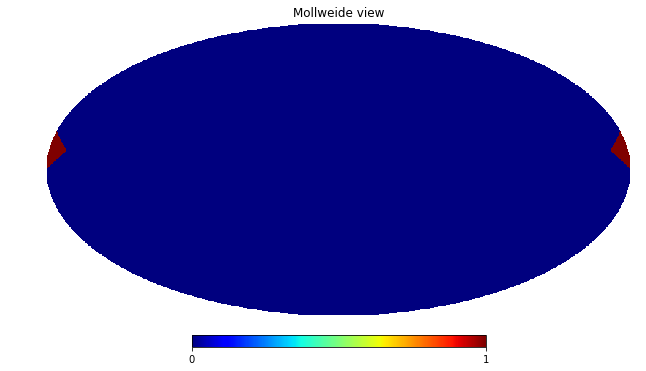

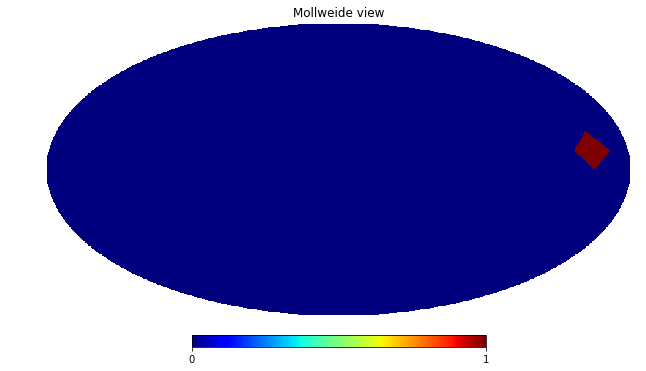

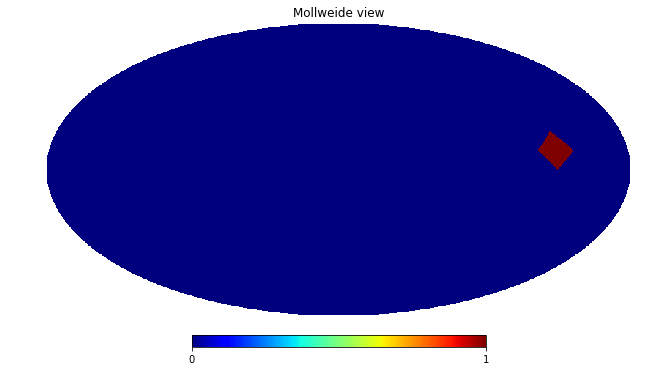

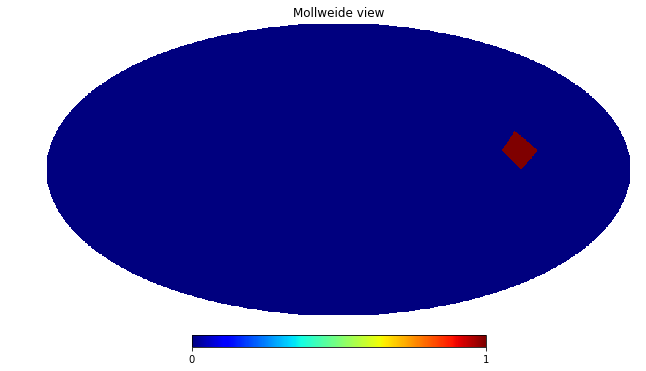

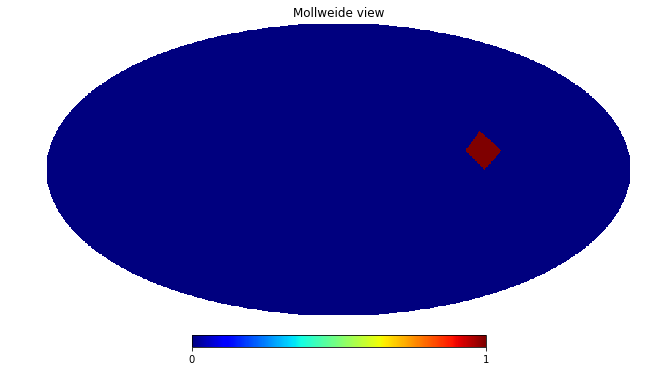

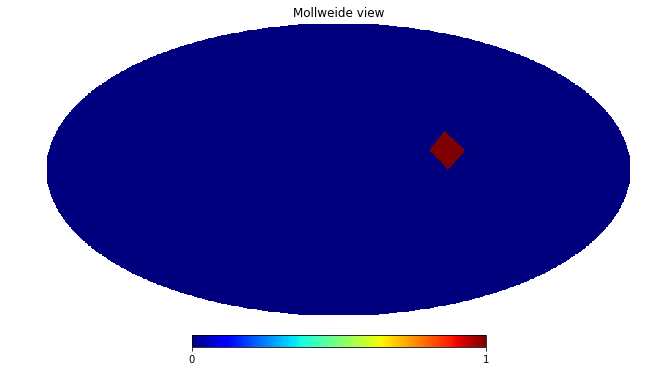

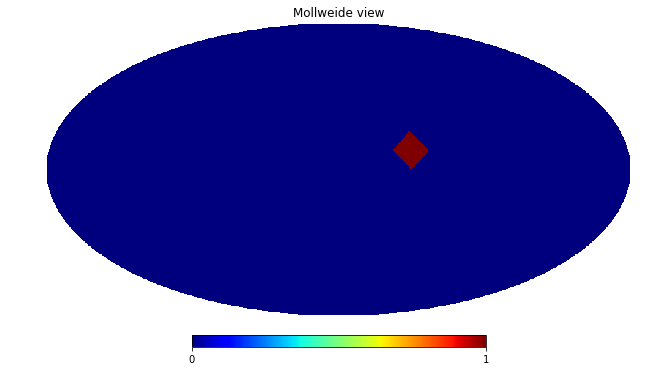

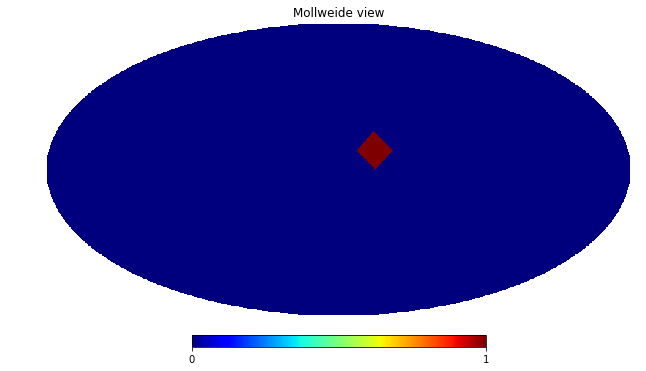

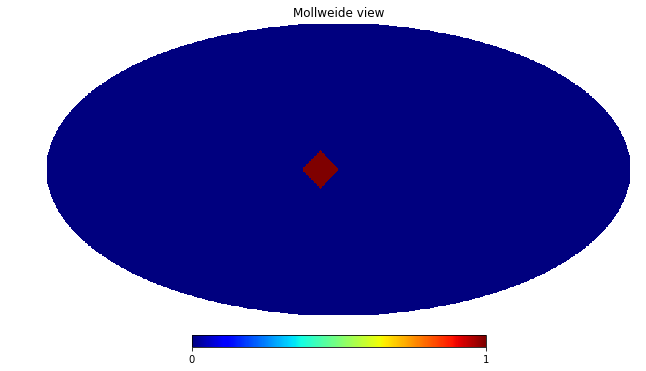

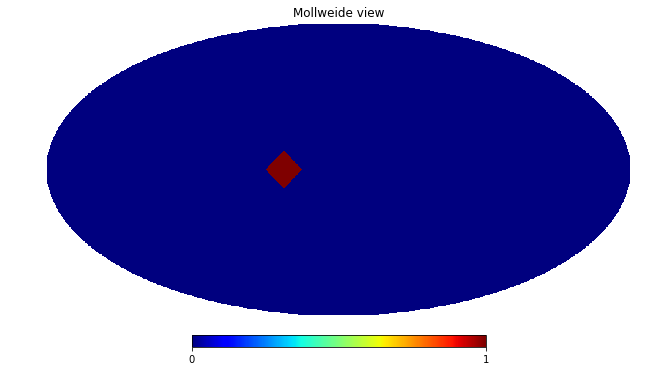

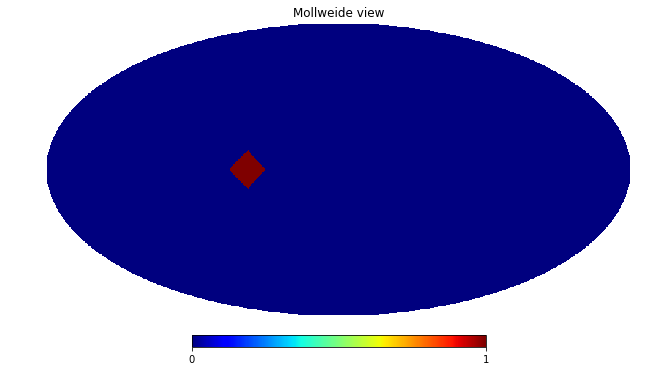

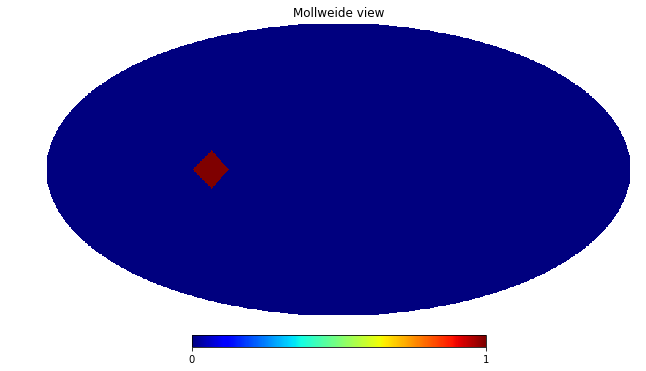

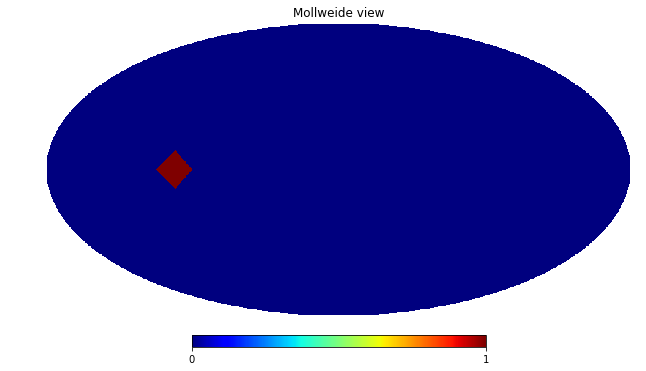

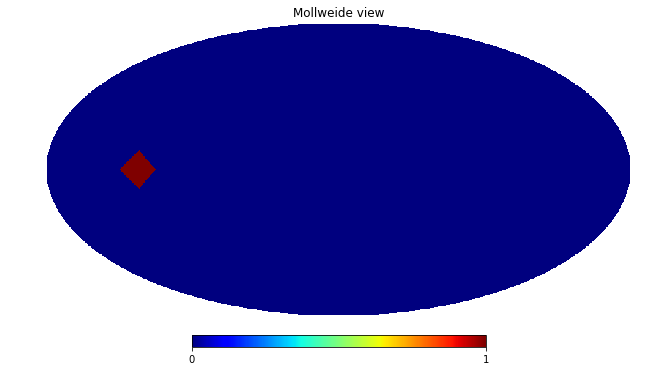

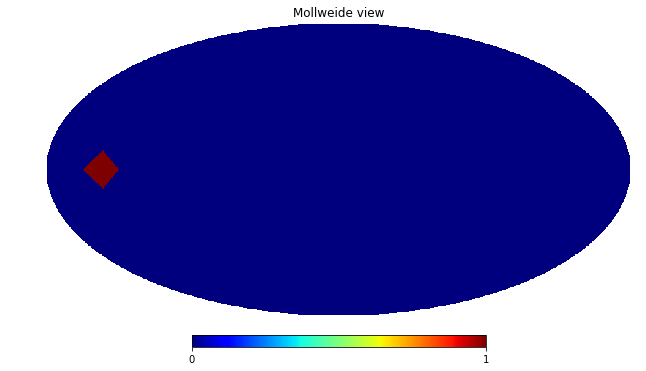

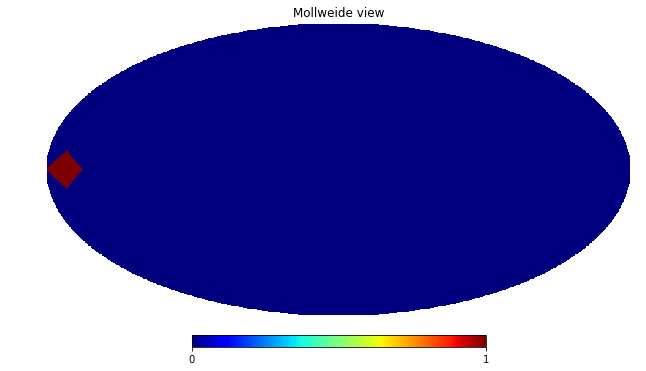

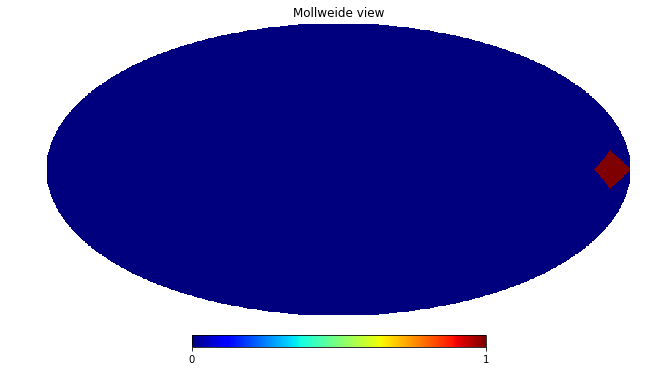

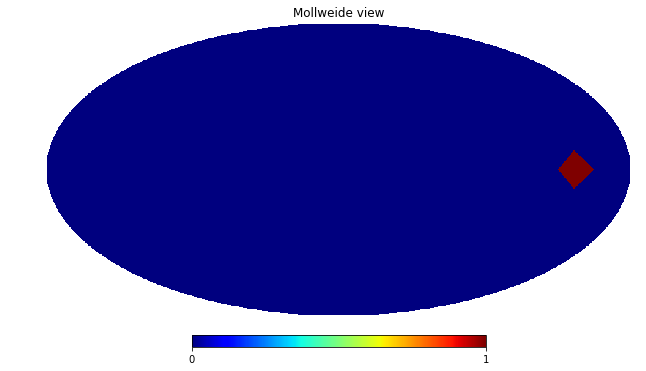

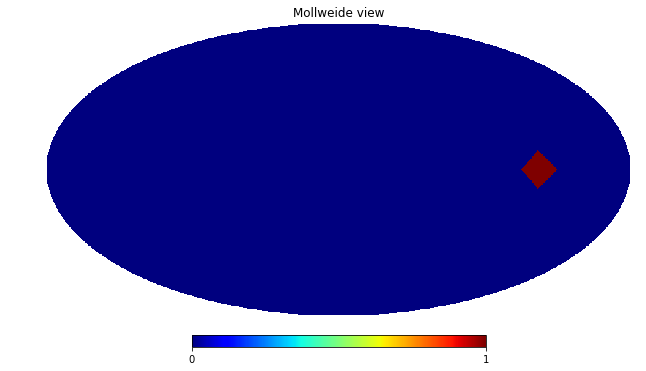

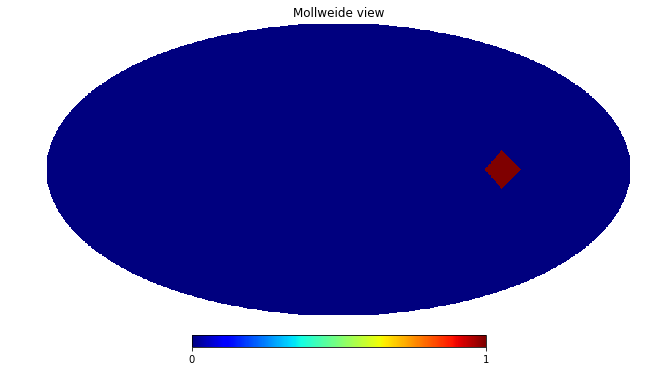

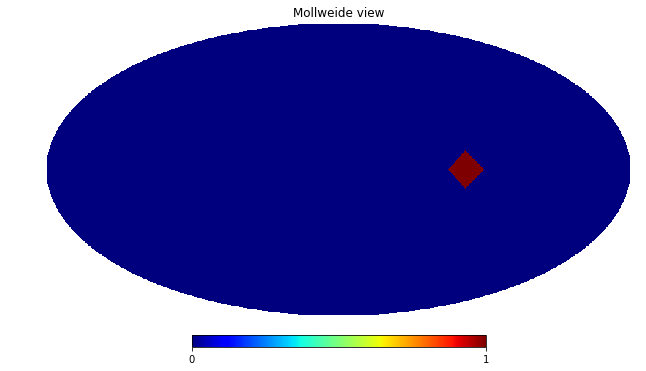

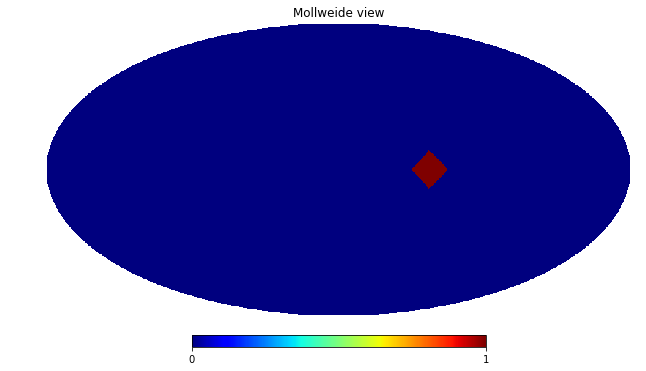

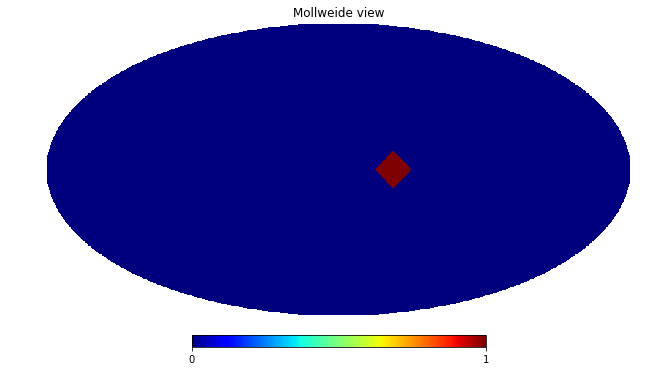

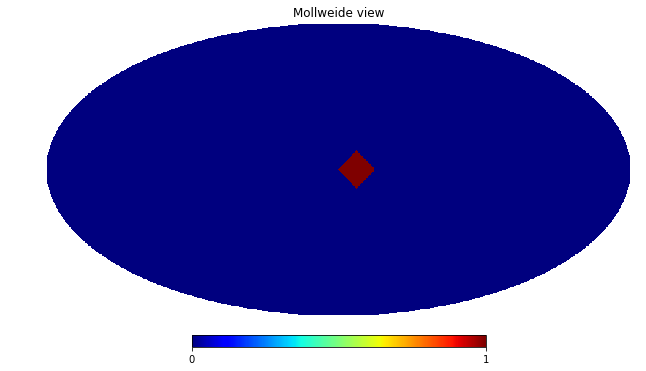

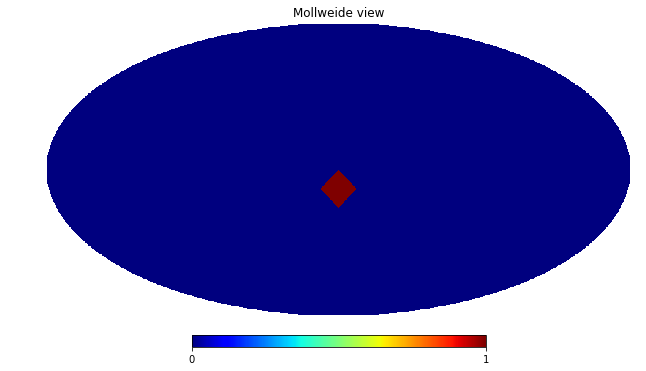

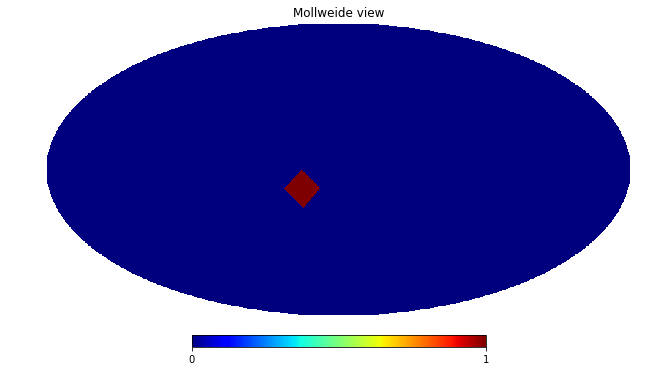

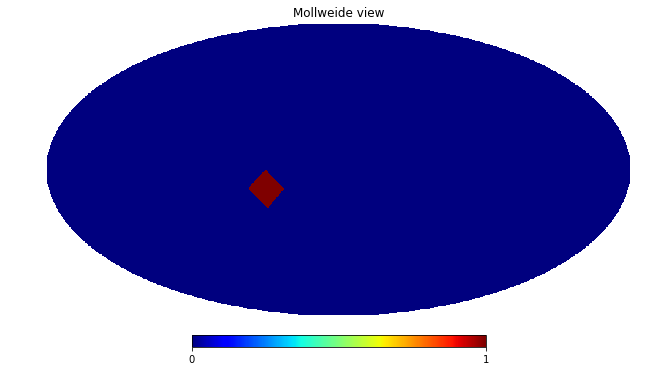

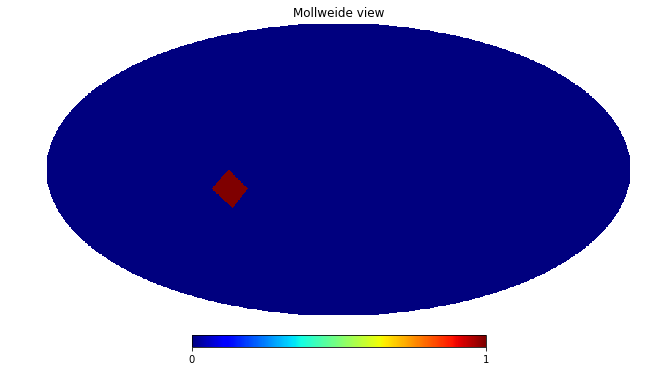

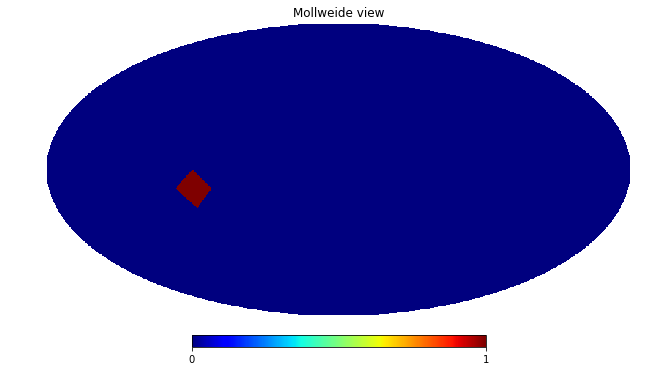

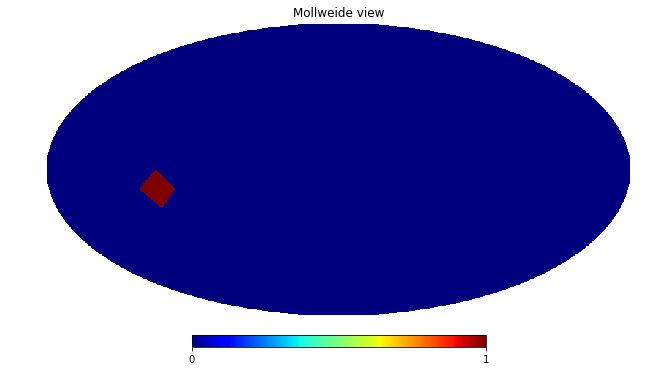

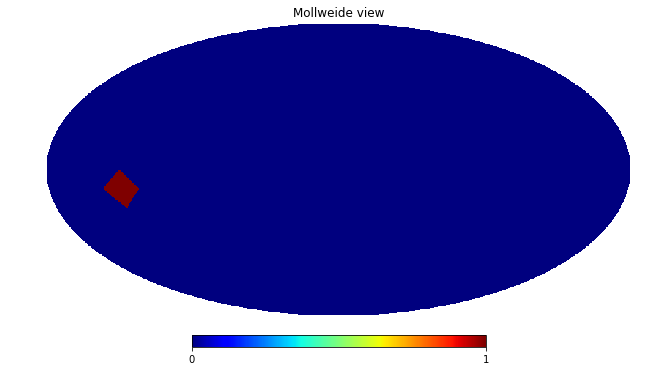

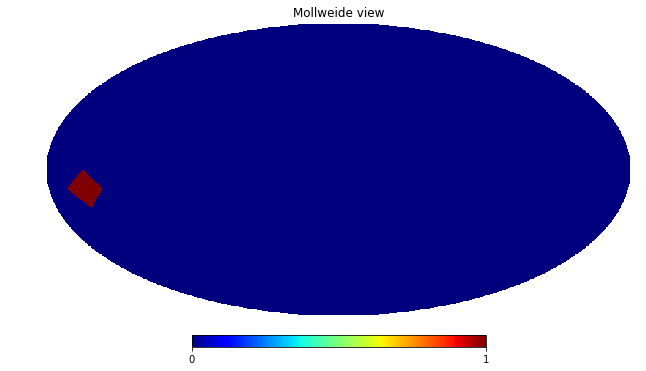

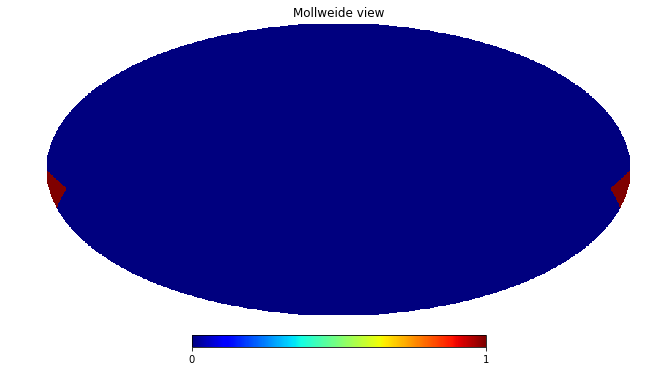

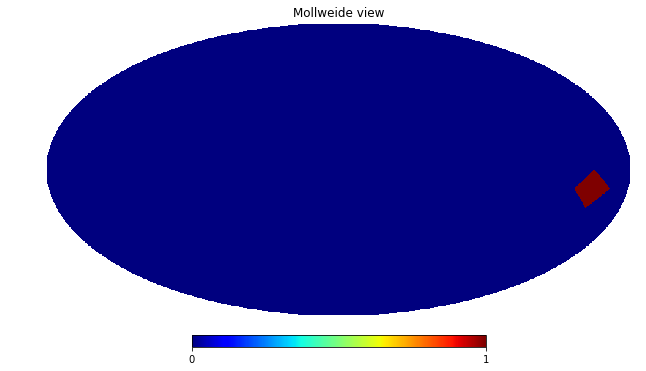

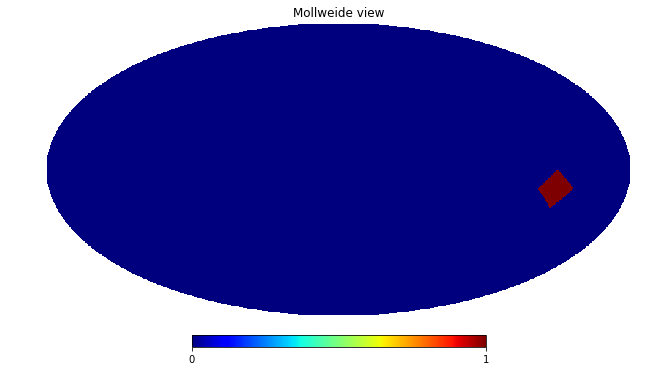

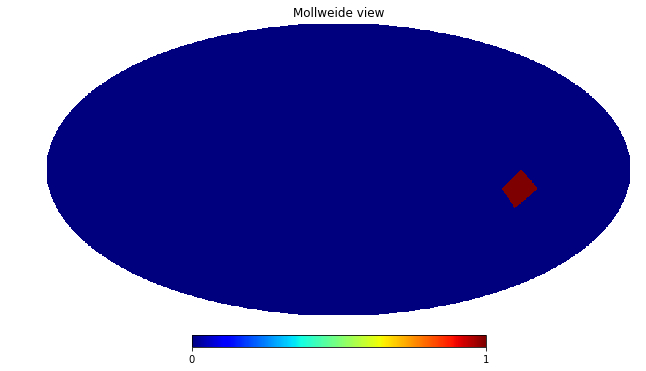

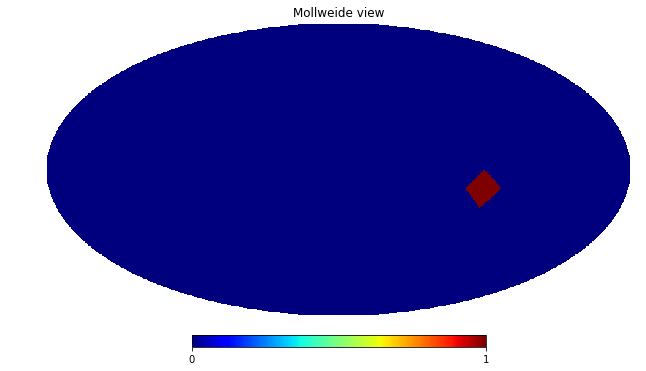

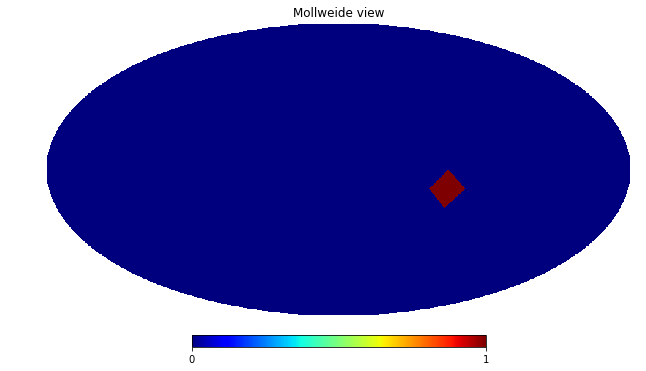

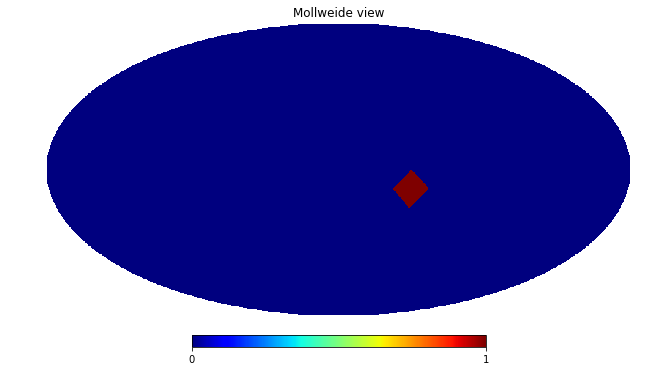

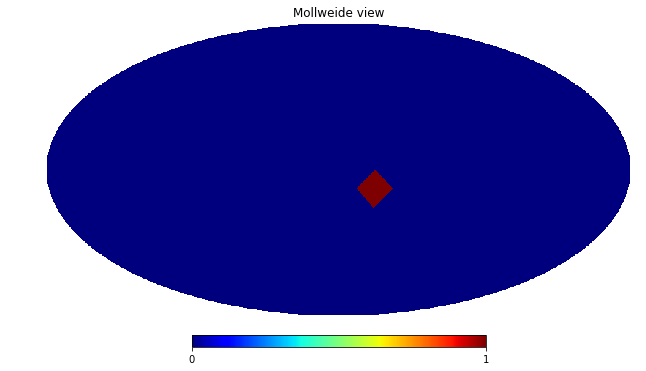

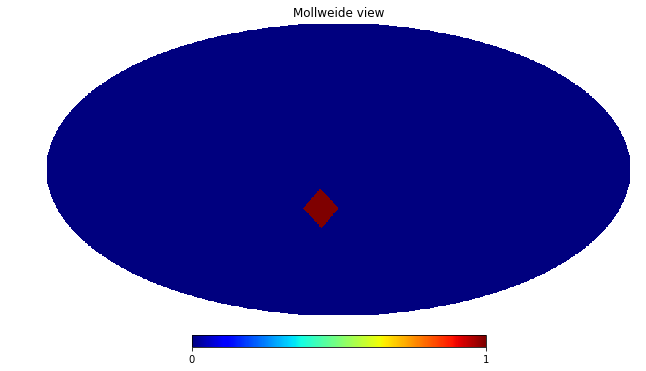

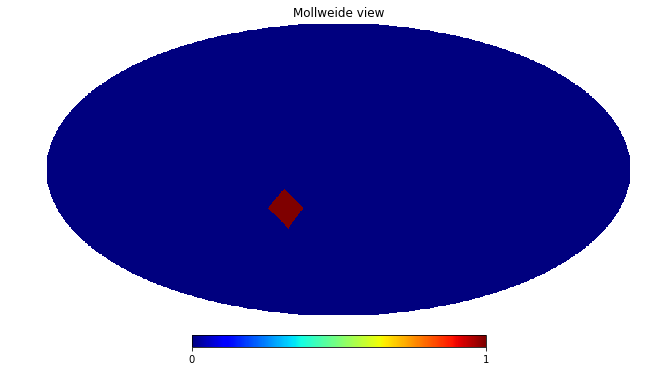

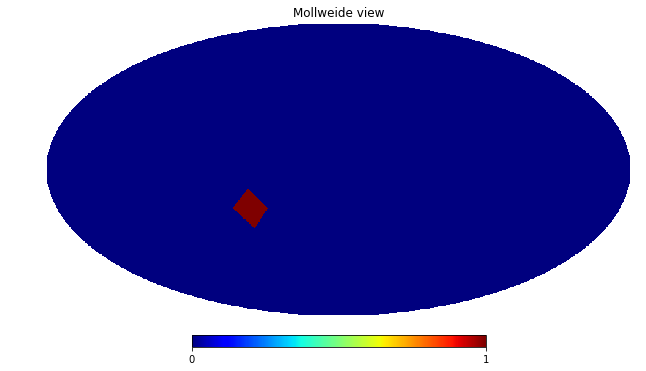

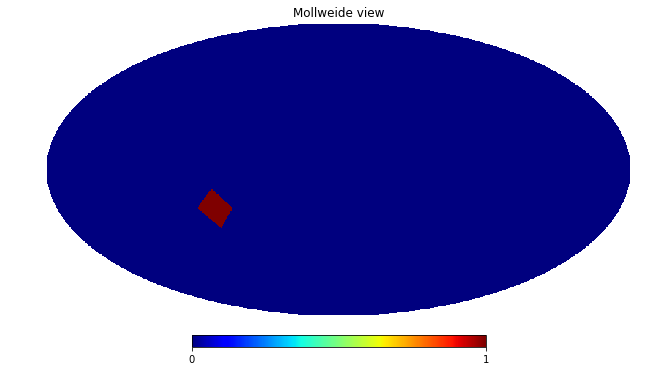

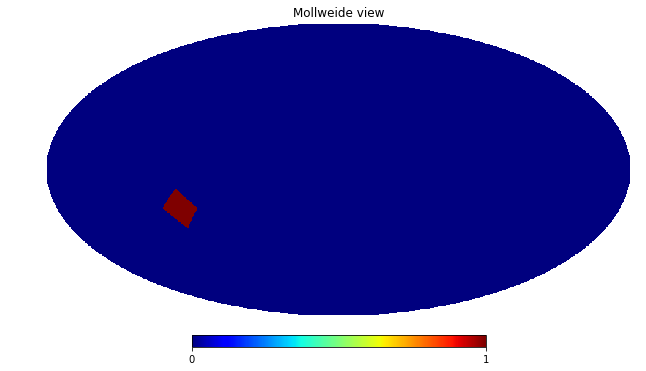

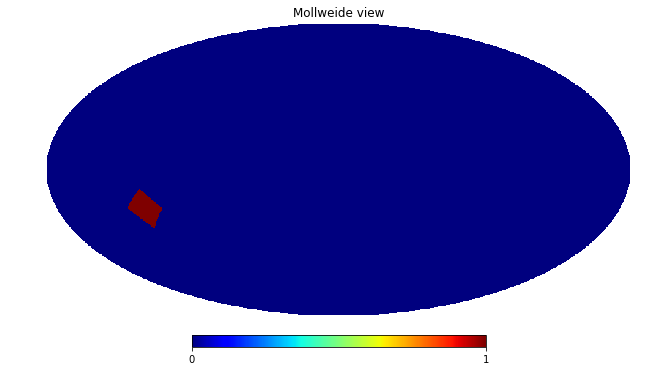

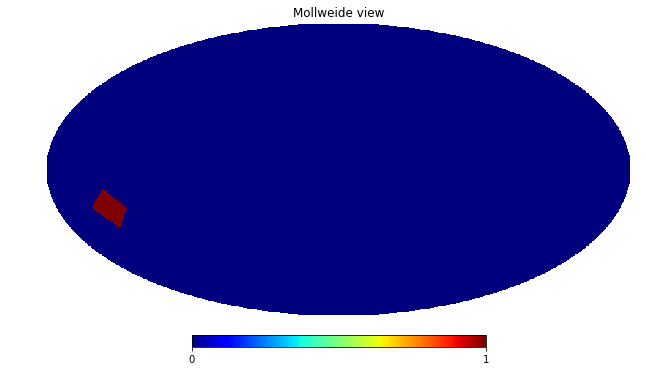

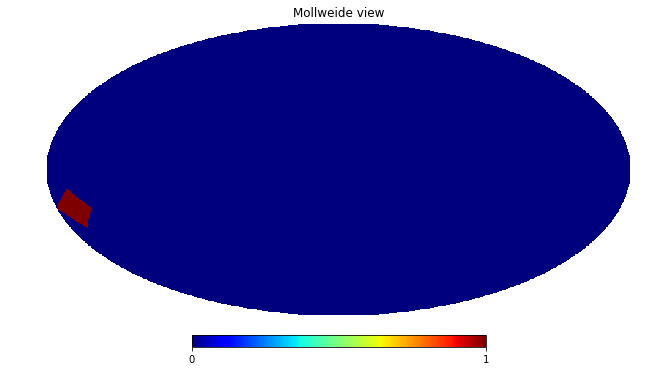

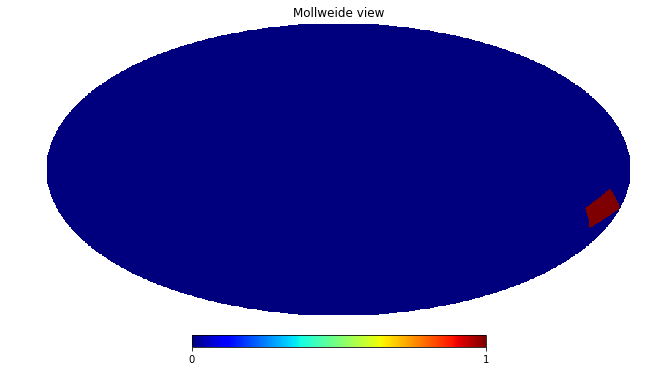

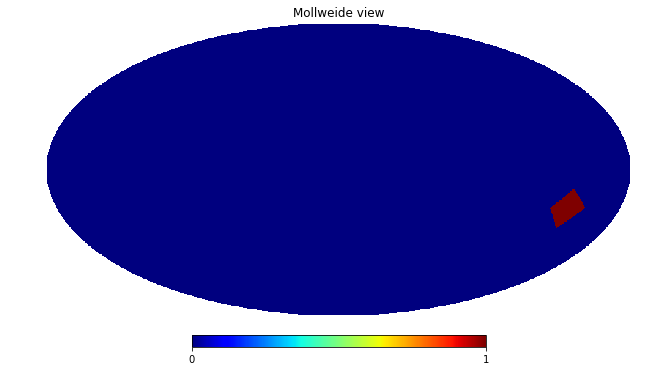

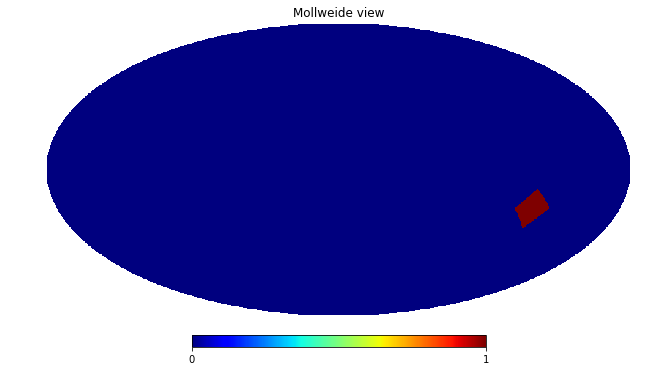

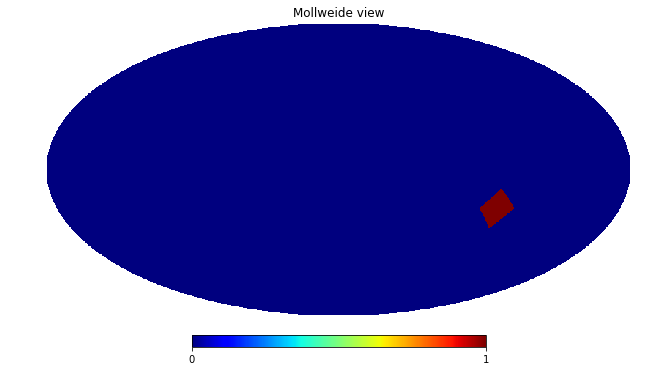

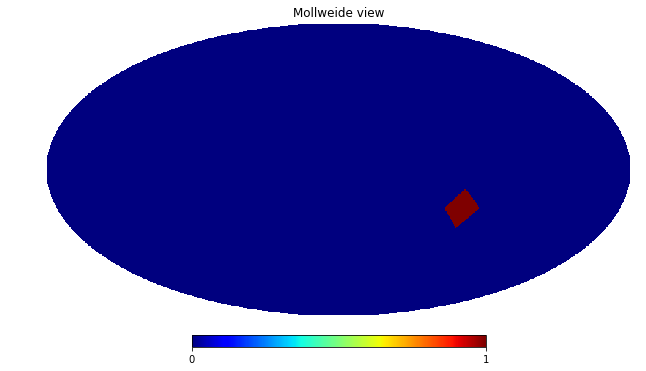

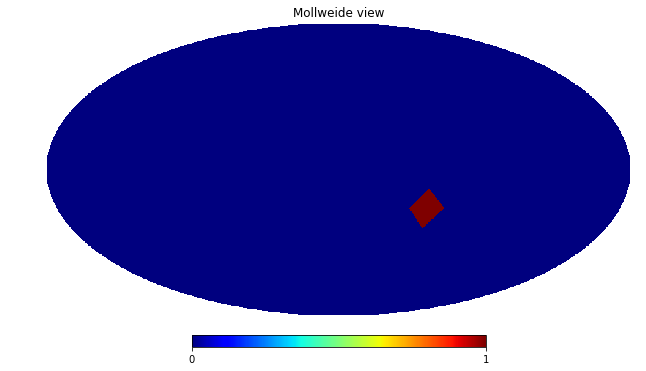

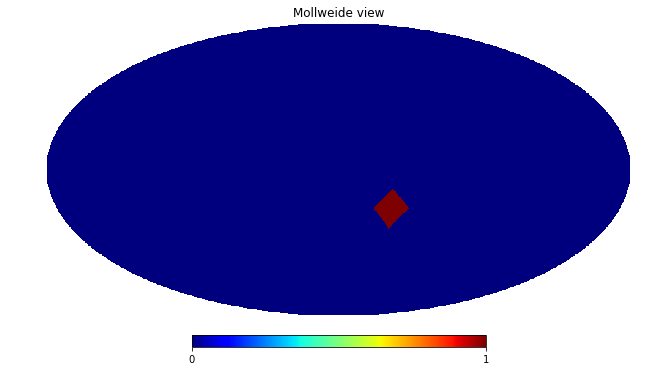

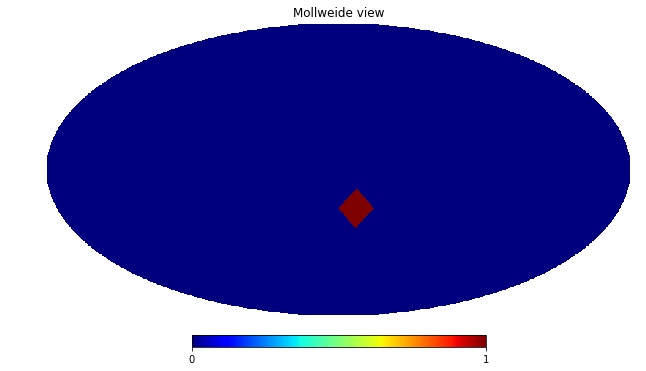

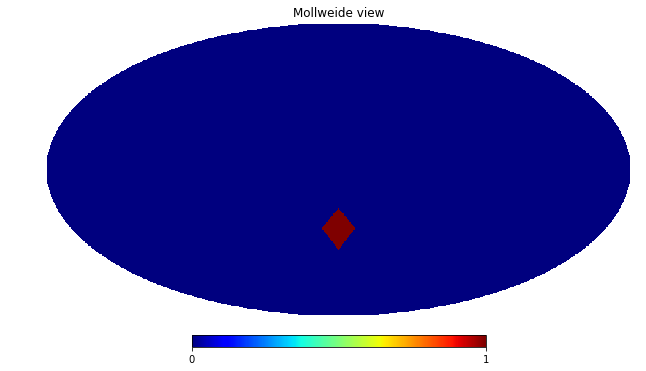

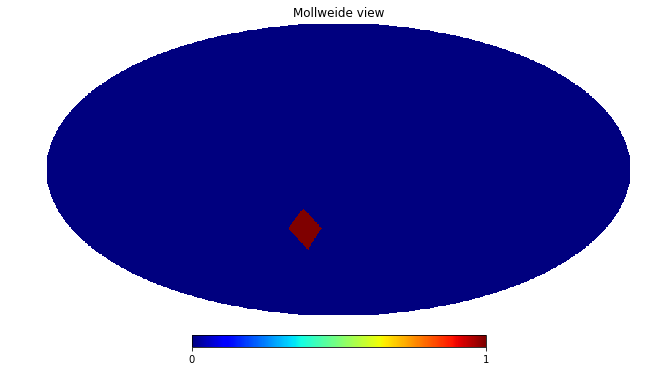

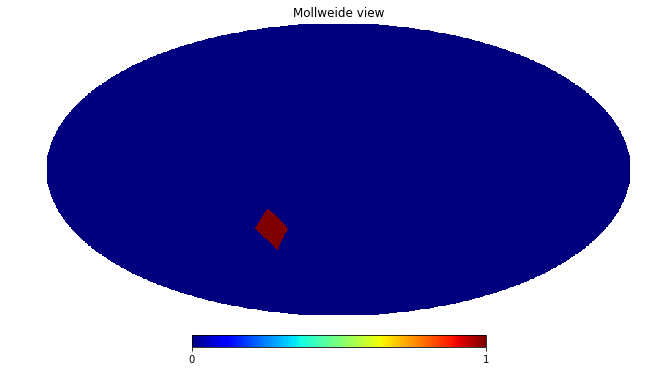

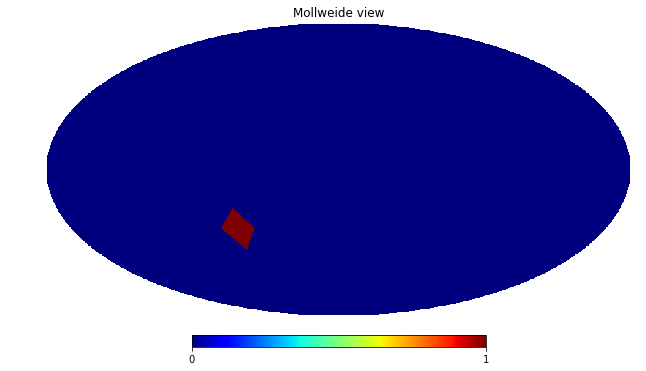

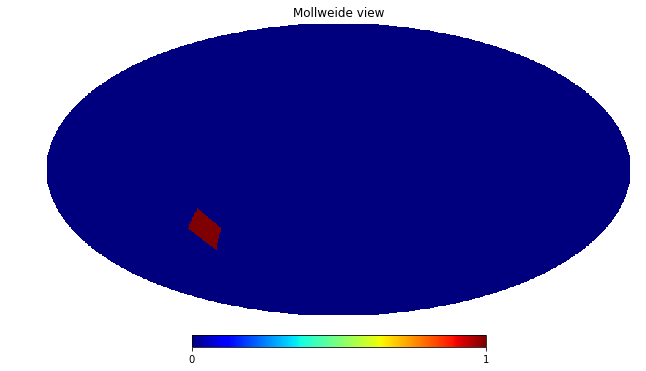

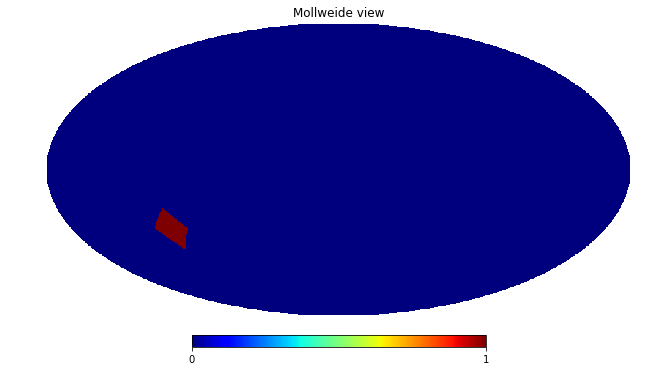

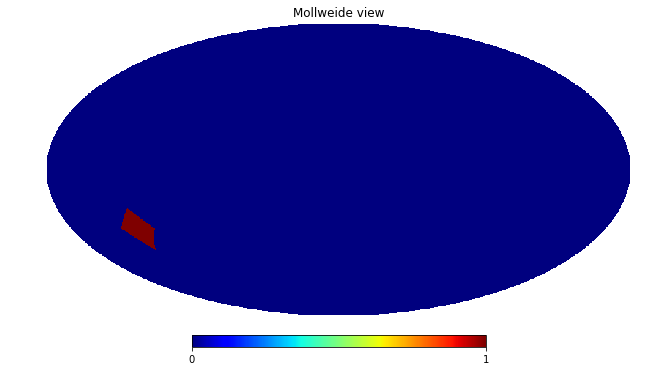

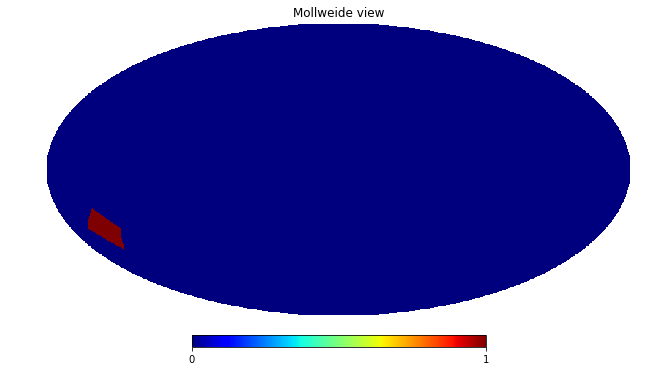

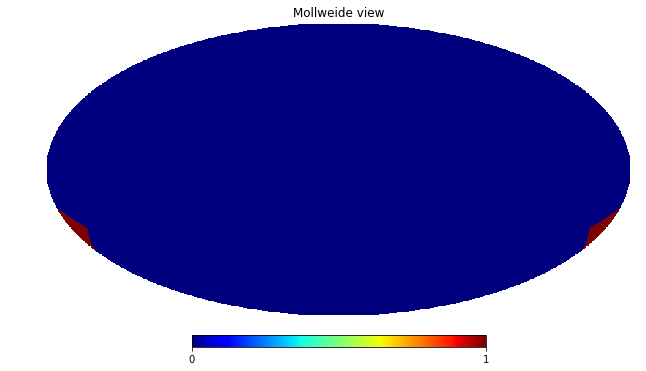

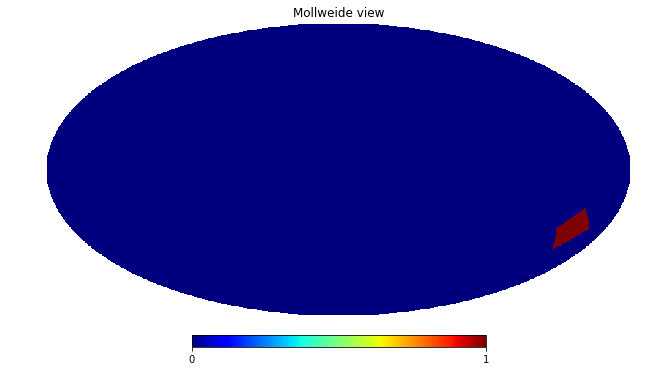

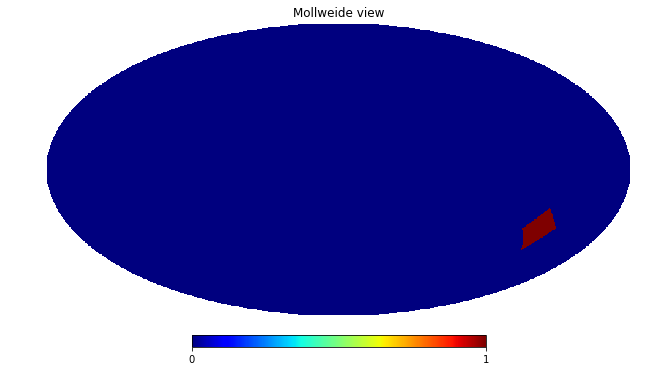

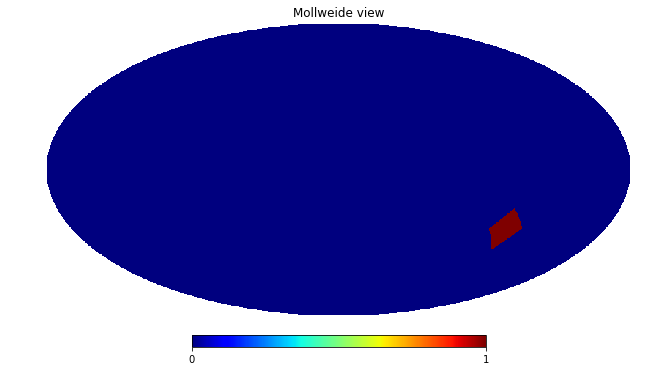

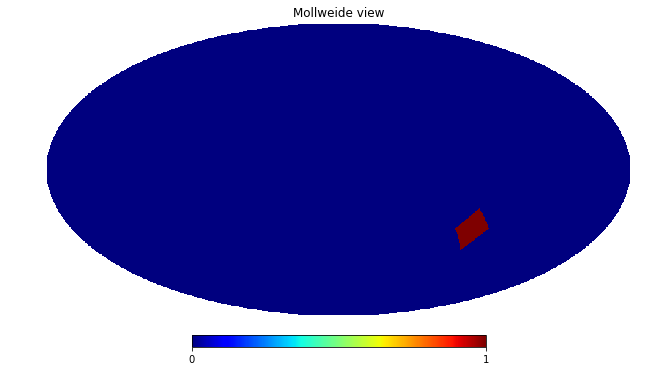

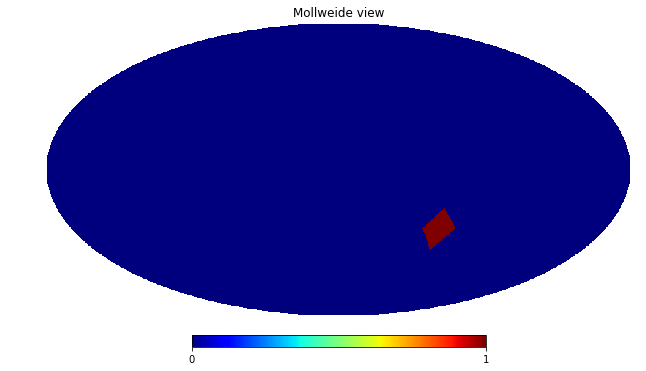

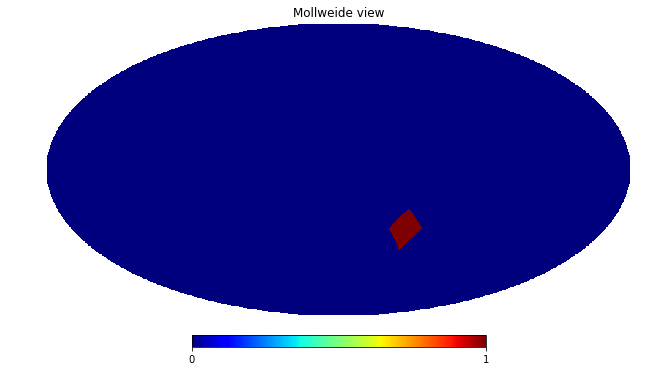

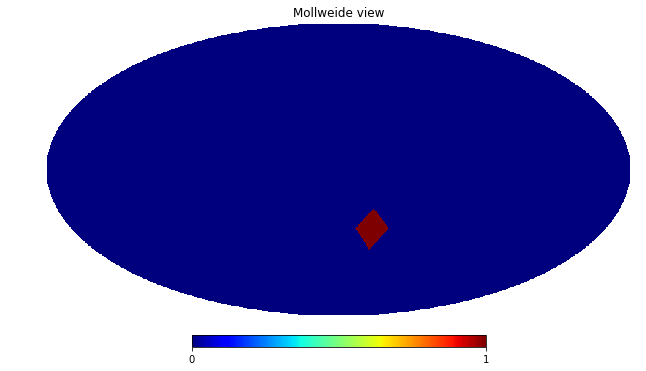

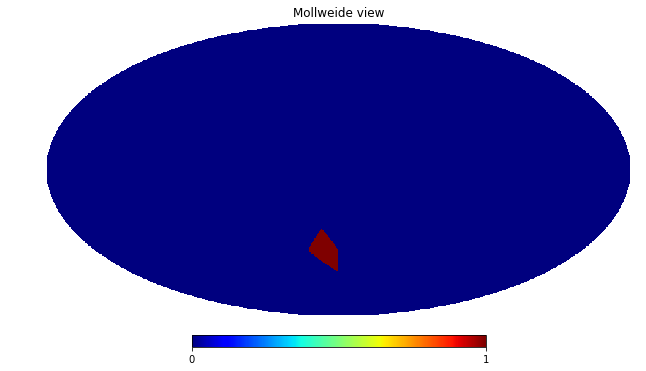

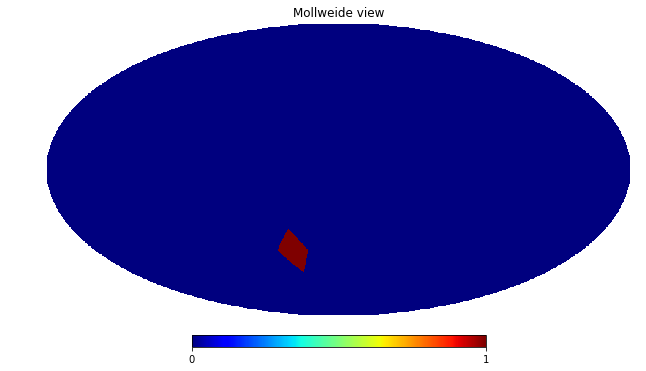

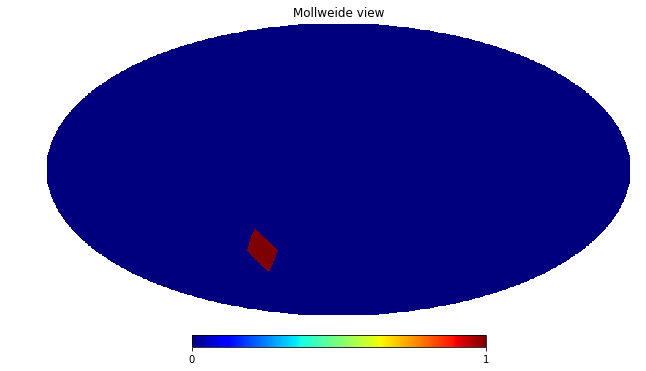

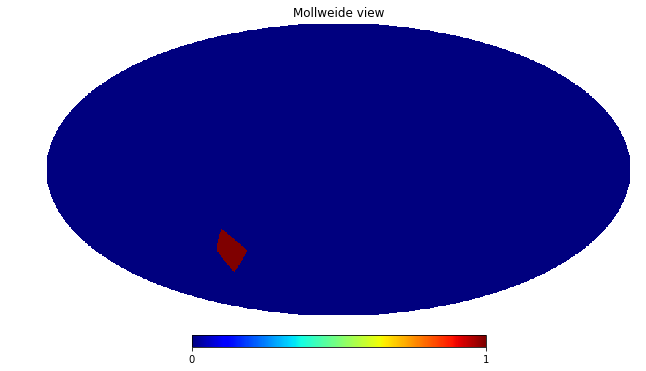

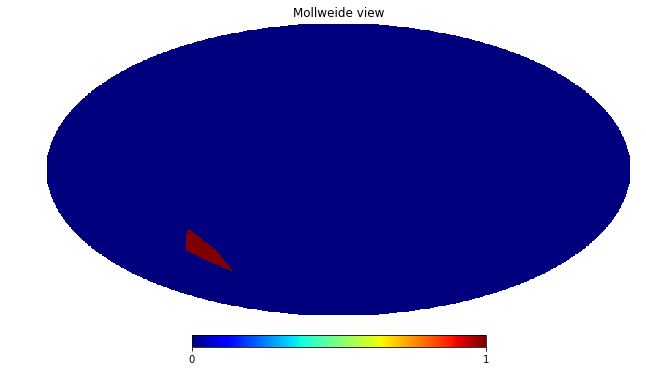

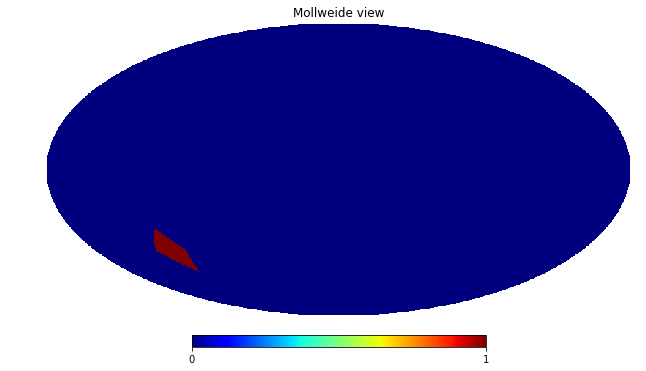

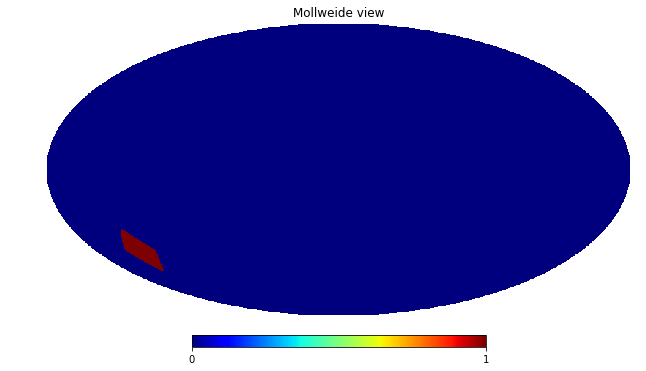

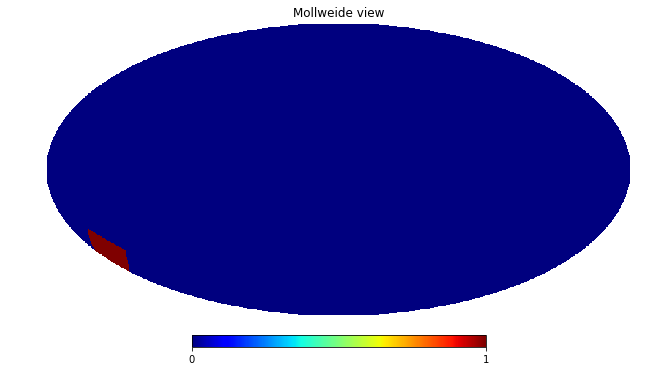

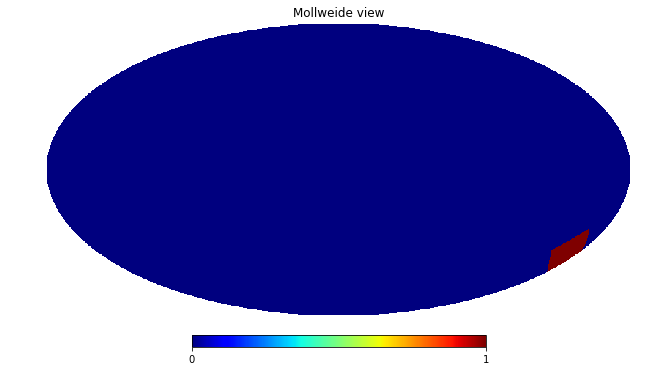

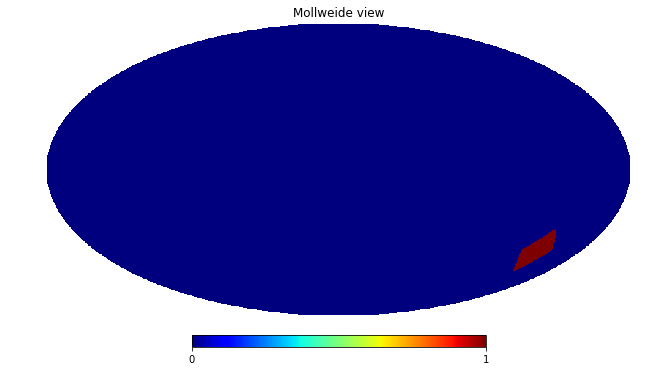

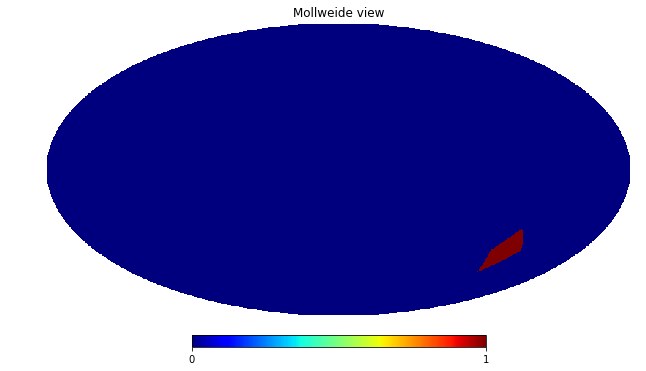

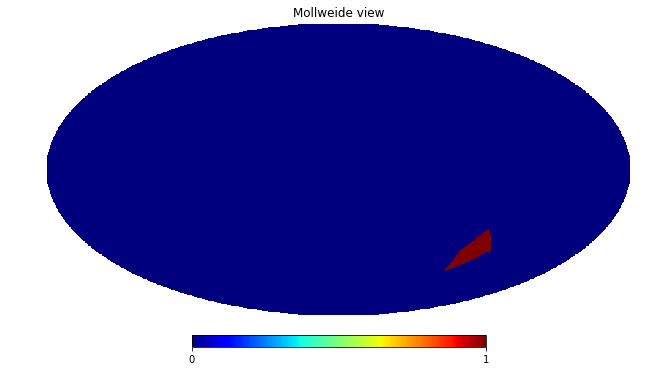

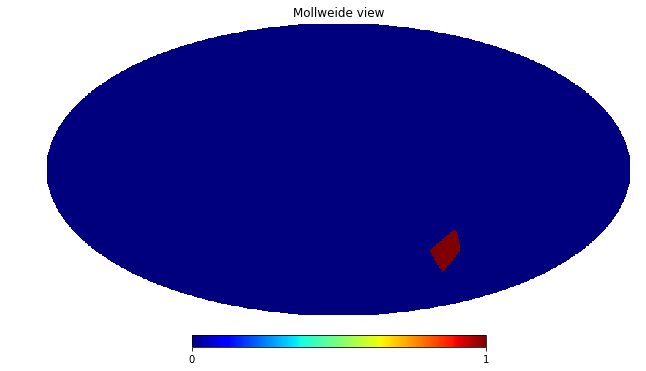

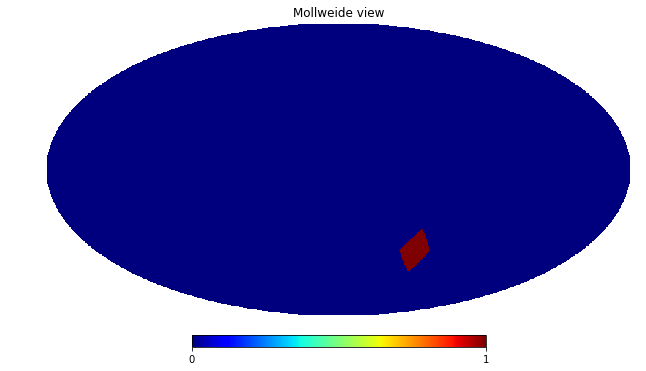

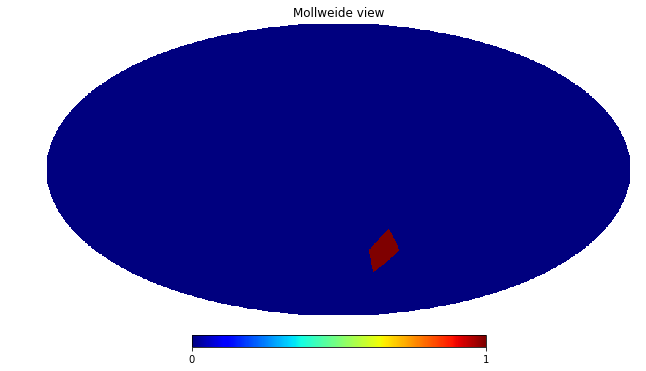

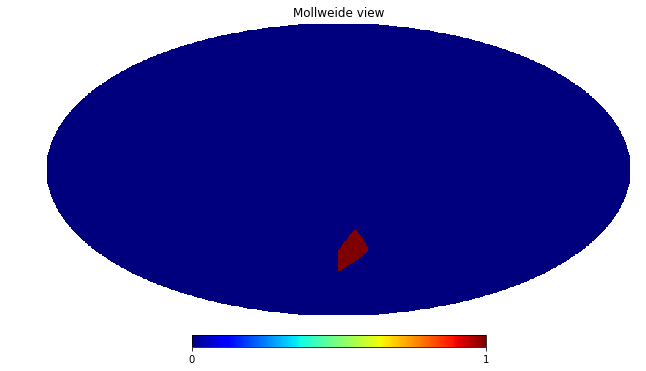

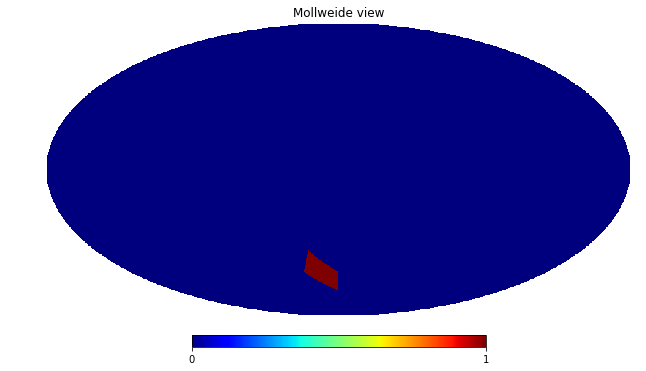

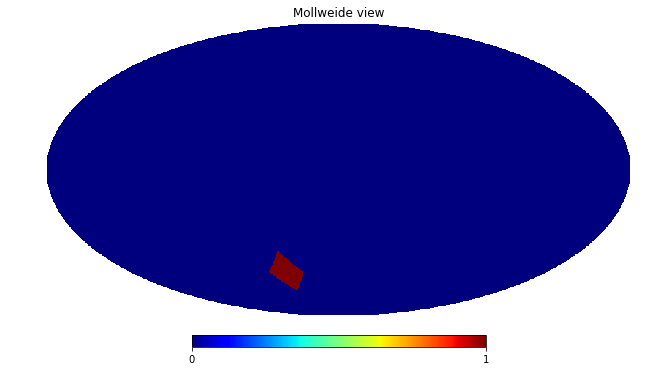

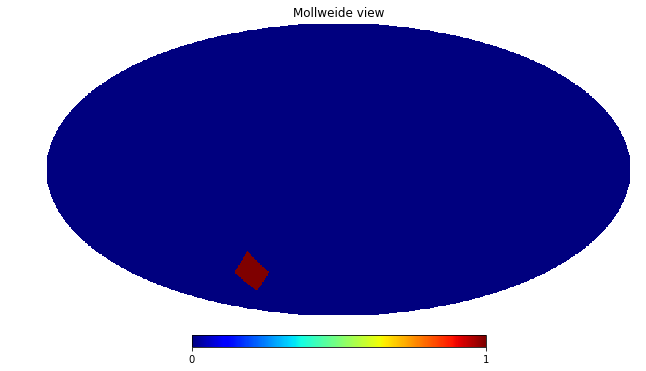

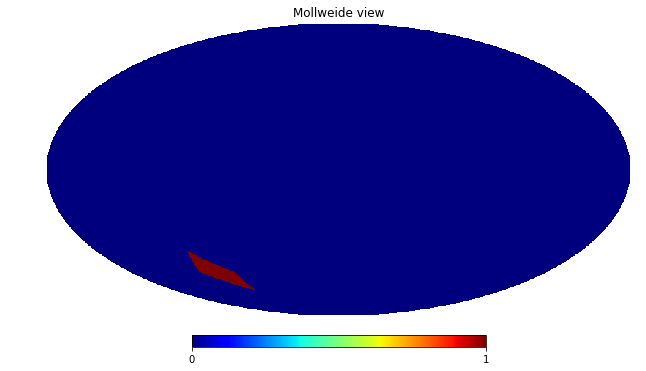

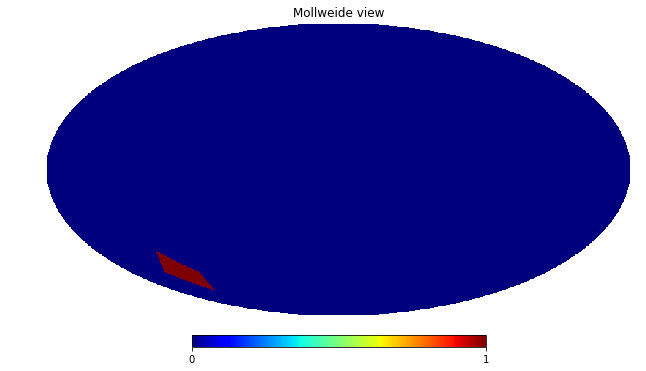

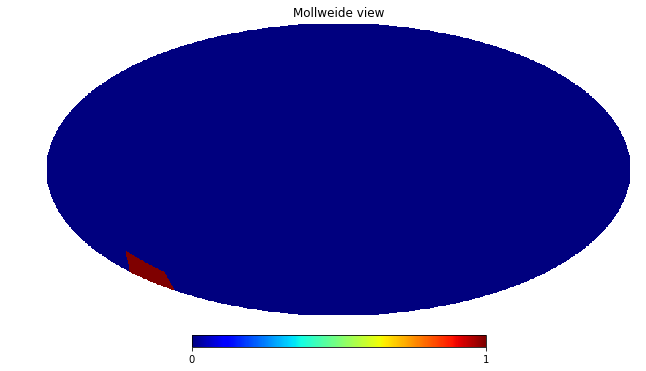

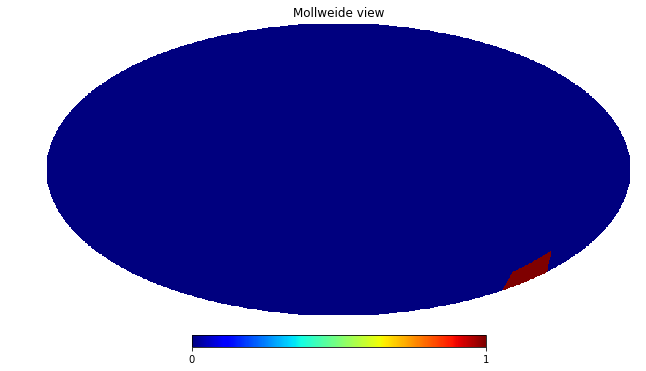

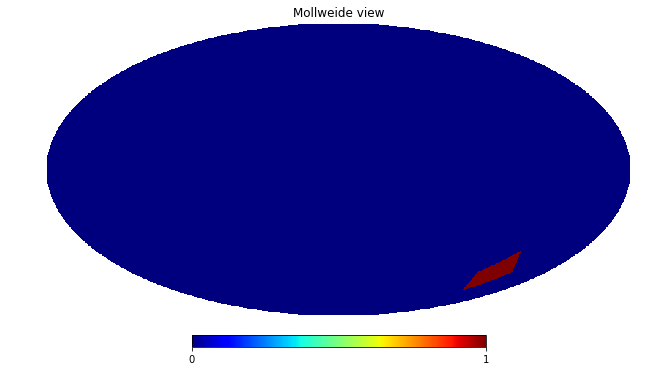

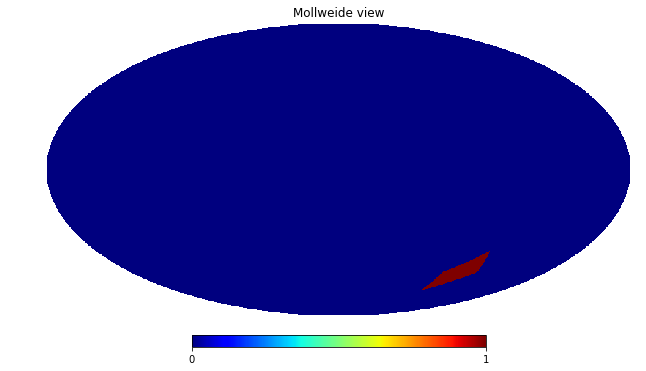

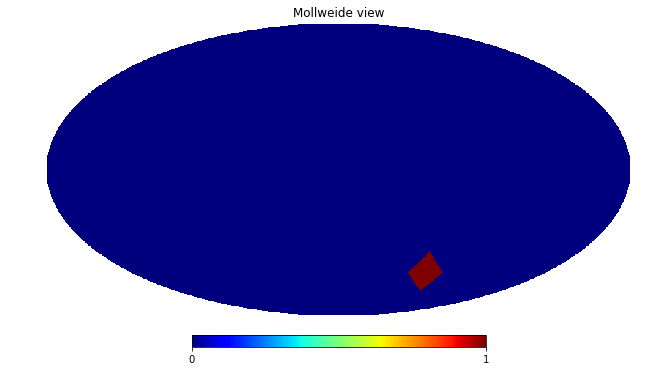

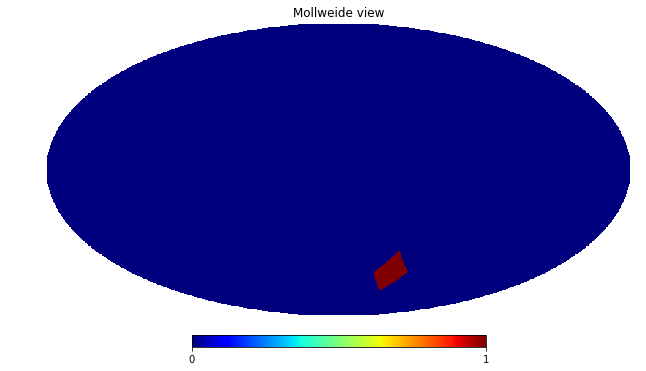

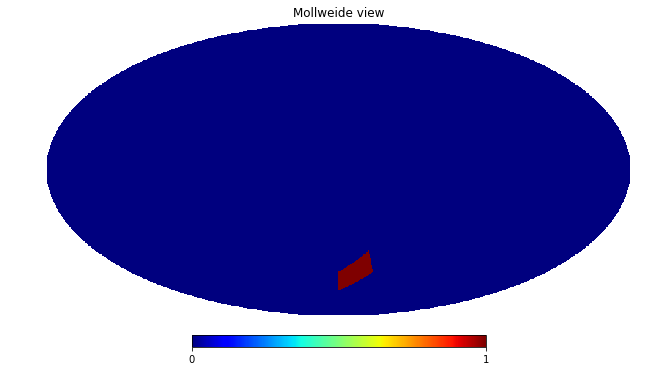

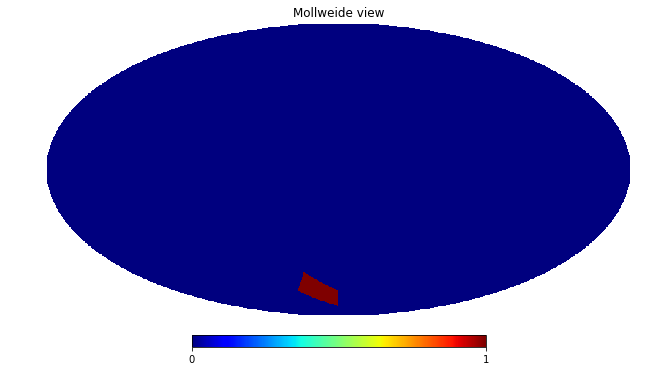

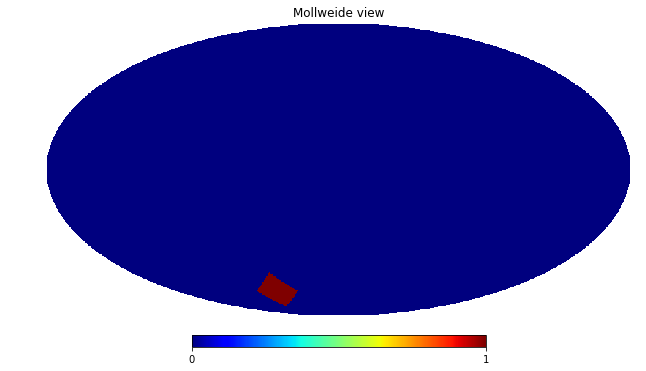

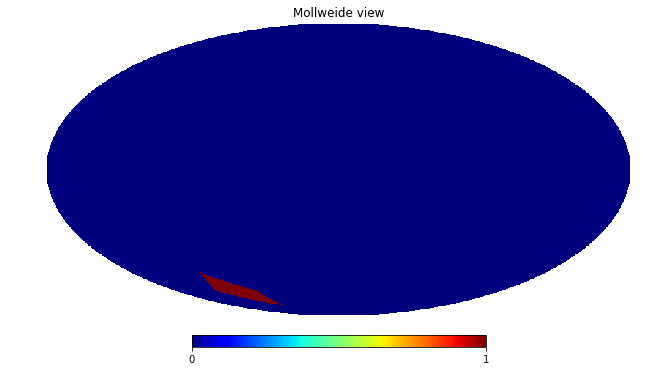

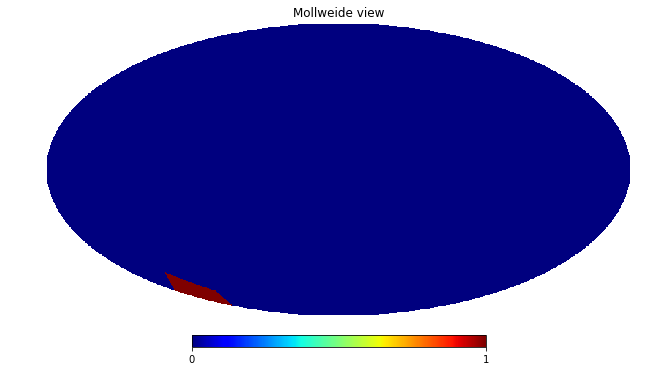

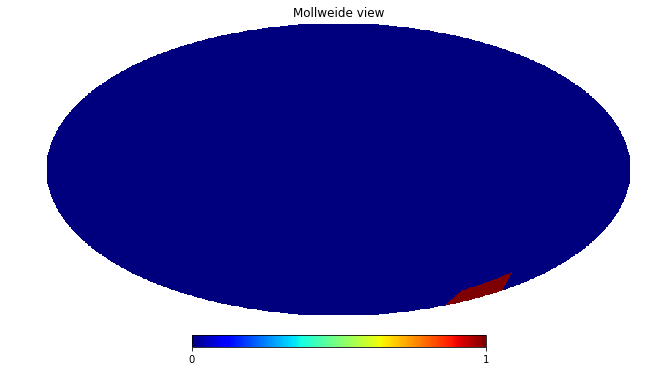

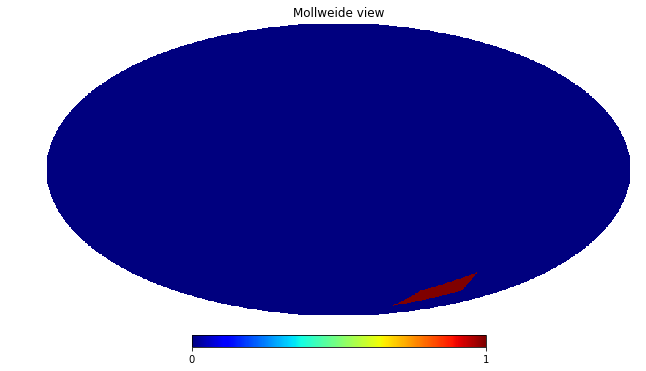

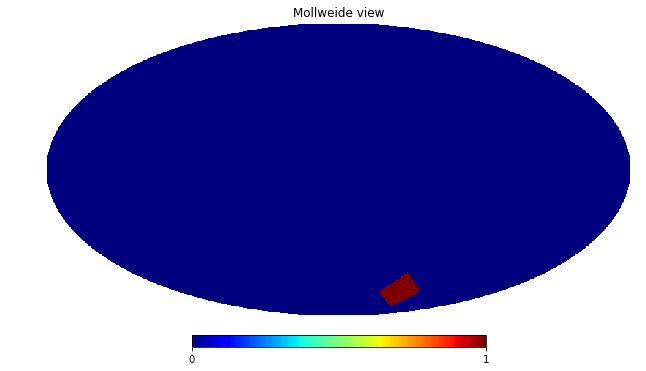

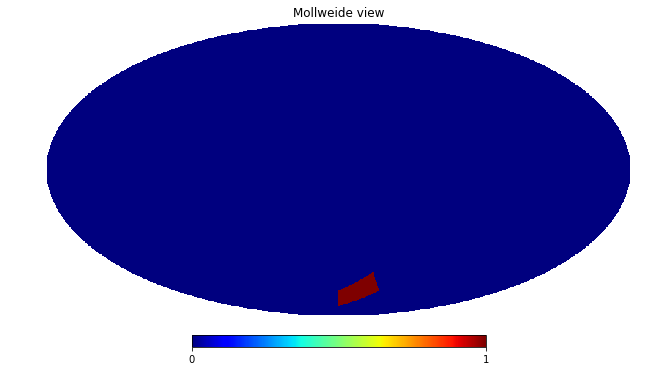

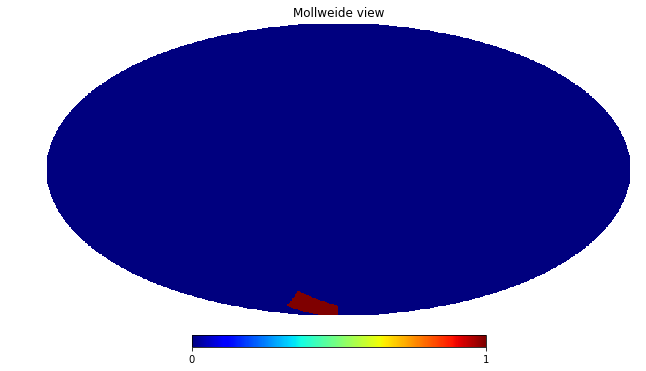

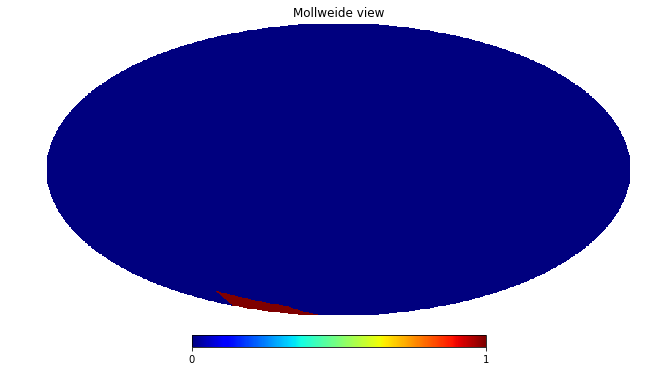

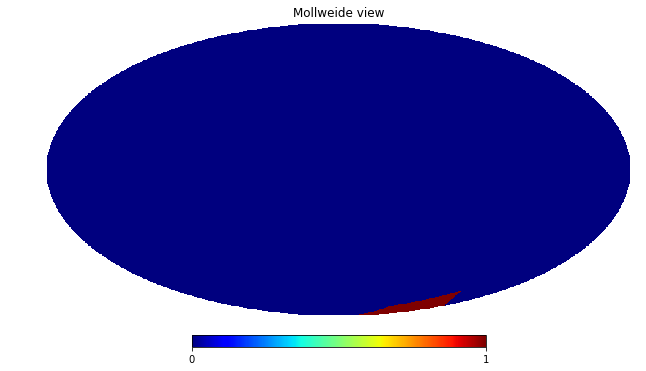

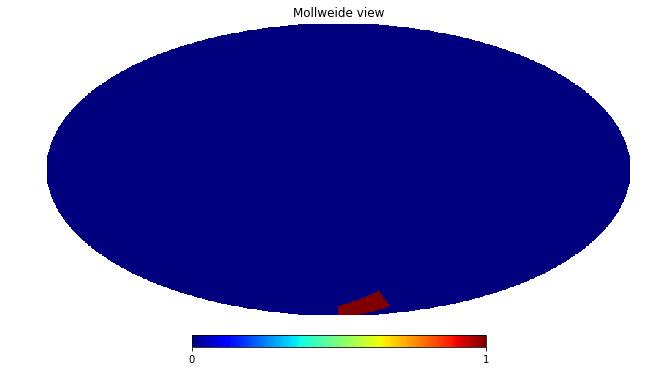

In [21]:
fig, axes = plt.subplots(4*nside, 3*nside, figsize=(8*nside, 8*nside))
axes = axes.flatten()
npix = hpix.npix # hp.nside2npix(nside)
pixelImages = []
for i in range(npix):
    mask = np.zeros(npix)
    mask[i] = 1.0
    map = hp.mollview(mask, return_projected_map=True)
    axes[i].imshow(map, origin='lower')
    pixelImages.append(map)
fig.savefig('pofd_sky.pdf')
plt.close(fig)

In [104]:
print len(sdsstbl['pmra_new'])
print len(sdsstbl['pmdec_new'])

21996393
21996393


In [164]:
nside = 4
hpix=hu.HealPix("ring", nside)
pixnums = hpix.eq2pix(sdsstbl['l'][metalcut], sdsstbl['b'][metalcut])

In [123]:
c = coord.ICRS(ra=sdsstbl['ra']*u.deg, dec=sdsstbl['dec']*u.deg, 
               pm_ra_cosdec=sdsstbl['pmra_new']*u.mas/u.yr, pm_dec=sdsstbl['pmdec_new']*u.mas/u.yr)

#c = coord.Galactic(u=data['px']*u.kpc, v=data['py']*u.kpc, w=data['pz']*u.kpc,
#                 U=data['vx']*u.km/u.s, V=data['vy']*u.km/u.s, W=data['vz']*u.km/u.s,
#                 representation=coord.CartesianRepresentation, differential_cls=coord.CartesianDifferential)
#c.set_representation_cls(coord.SphericalRepresentation, s=coord.SphericalCosLatDifferential)

In [128]:
cGal = c.transform_to(coord.Galactic)

In [168]:
galactic = True
ecliptic = False
logarithmic = True
linear = False
if galactic:

    x = cGal.pm_l_cosb[metalcut].value
    y = cGal.pm_b[metalcut].value
    xl = 'l'
    yl = 'b'
if ecliptic:
    
    x = sdsstbl['pmra_new'][metalcut]
    y = sdsstbl['pmdec_new'][metalcut]
    xl = 'ra'
    yl = 'dec'

if logarithmic:
    pmlim = 2

if linear:
    pmlim = 100

x = np.sign(x)*(np.log10(abs(x)+1))
y = np.sign(y)*(np.log10(abs(y)+1))

nbins = 200
bins = [np.linspace(-pmlim, pmlim, nbins), np.linspace(-pmlim, pmlim, nbins)]
xlabel = 'log pm ' + xl + ' + 1'
ylabel = 'log pm ' + yl + ' + 1'
fignameAll = 'pm'+xl + yl+'_allPixels_sdss.pdf'
fignameEachpre = 'pm'+xl + yl+'_sdss'
plotPixels(x, y, pixnums, mapSky, pixelImages, plotEach=True, 
               xlim=(pmlim, -pmlim), ylim=(pmlim, -pmlim), vmin=None, vmax=None, xlabel=xlabel, ylabel=ylabel, 
              fignameAll=fignameAll, fignameEachpre=fignameEachpre, bins=bins, norm='lognorm', 
           normed=False, cmap='inferno_r', grid=True, dynRange=16.)

In [11]:
def plotvector(mean, var, step=0.001):
    """
    mean, var should be *projected* to the 2-d space in which plotting is about to occur
    """
    assert mean.shape == (2,)
    assert var.shape ==	(2, 2)
    ts = np.arange(0, 2. * np.pi, step) #magic
    w, v = np.linalg.eigh(var)
    ps = np.sqrt(w[0]) * (v[:, 0])[:,None] * (np.cos(ts))[None, :] + \
         np.sqrt(w[1]) * (v[:, 1])[:,None] * (np.sin(ts))[None, :] + \
         mean[:, None]
    return ps

In [12]:
def plotGMM(xdgmm, ax=None, c='k', lw=1, labels='prior', indices=[[0,1]]):
    for gg in range(xdgmm.n_components):
        if xdgmm.weights[gg] == np.max(xdgmm.weights):
            label = 'gaussian mixture model'
        else:
            label = None
        for axis, ind, l in zip(ax, indices, labels):
            mean = xdgmm.mu[gg][ind]
            var = xdgmm.V[gg][ind[0]:ind[1]+1,ind[0]:ind[1]+1]
            weight = xdgmm.weights[gg]
            points = plotvector(mean, var)
            if l == 'pm':
                x = points[0,:]
                y = points[1,:]
                if axis: axis.plot(logNegative(x), logNegative(y), c, lw=lw,
                        alpha=weight/np.max(xdgmm.weights), label=label, rasterized=True)
                else: plt.plot(logNegative(x), logNegative(y), c, lw=lw,
                        alpha=weight/np.max(xdgmm.weights), label=label, rasterized=True)

            else:
                if axis: axis.plot(points[0,:], points[1,:], c, lw=lw,
                alpha=weight/np.max(xdgmm.weights), label=label, rasterized=True)
                else: plt.plot(points[0,:], points[1,:], c, lw=lw,
                alpha=weight/np.max(xdgmm.weights), label=label, rasterized=True)

In [13]:
def logNegative(x):
    return np.sign(x)*np.log10(np.abs(x) + 1.)

In [14]:
def matrixize(data, err):
    """
    vectorize the 2 pieces of data into a 2D mean and 2D covariance matrix
    """
    X = np.vstack(data).T
    Xerr = np.zeros(X.shape + X.shape[-1:])
    diag = np.arange(X.shape[-1])
    Xerr[:, diag, diag] = np.vstack([e**2. for e in err]).T
    return X, Xerr

In [15]:
def std(x, n):
    return np.sqrt(np.sum((x - np.mean(x, axis=0))**2., axis=0)/(n - 1))

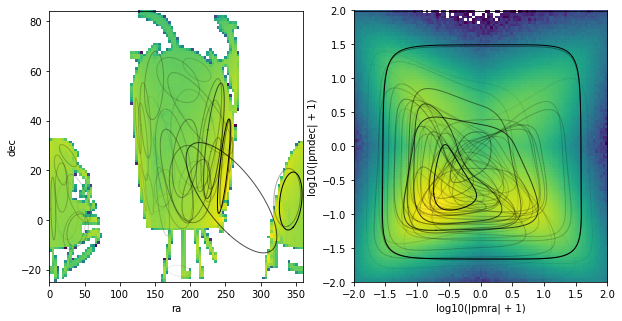

In [17]:
ngauss = 62
xdgmmFilename1 = 'gaiasdss.radecpmrapmdec.ngauss' + str(ngauss)
#xdgmmFilename2 = 'gaiasdss.radeclogpmrapmdec.ngauss' + str(ngauss)
xdgmmFilename3 = 'gaiasdss.lbpmlpmb.ngauss' + str(ngauss)
#xdgmmFilename4 = 'gaiasdss.lblogpmlpmb.ngauss' + str(ngauss)

xdgmmfilename = xdgmmFilename1

fig, axes = plt.subplots(1, 2, figsize=(10, 5))
axes = axes.flatten()

pmlim = 2
nbins = 100
bins = [np.linspace(-pmlim, pmlim, nbins), np.linspace(-pmlim, pmlim, nbins)]
axes[0].hist2d(sdsstbl['ra'], sdsstbl['dec'], bins=100, norm=mpl.colors.LogNorm())
axes[1].hist2d(logNegative(sdsstbl['pmra_new']), logNegative(sdsstbl['pmdec_new']), bins=bins, norm=mpl.colors.LogNorm())

xdgmm = XDGMM(filename=xdgmmfilename)
plotGMM(xdgmm, ax = axes, indices=[[0,1],[2,3]], labels=['pos', 'pm'])
axes[0].set_xlabel('ra')
axes[0].set_ylabel('dec')
axes[1].set_xlabel('log10(|pmra| + 1)')
axes[1].set_ylabel('log10(|pmdec| + 1)')
axes[1].set_xlim(-2, 2)
axes[1].set_ylim(-2, 2)
fig.savefig('gmmradec.pdf')

In [ ]:
c = coord.ICRS(ra=sdsstbl['s_ra1']*u.deg, dec=sdsstbl['s_dec1']*u.deg,
               pm_ra_cosdec=sdsstbl['pmra_new']*u.mas/u.yr, pm_dec=sdsstbl['pmdec_new']*u.mas/u.yr)
cGal = c.transform_to(coord.Galactic)
pmerr = np.zeros(len(sdsstbl)) + 2.

X, Xerr = matrixize([sdsstbl['s_ra1'], sdsstbl['s_dec1'], sdsstbl['pmra_new'], sdsstbl['pmdec_new']],
                    [sdsstbl['ra_error']/3600., sdsstbl['dec_error']/3600., pmerr, pmerr])

xdgmm = XDGMM(method='Bovy')
xdgmm.n_components = ngauss
xdgmm = xdgmm.fit(X, Xerr)
xdgmm.save_model(xdgmmFilename1)


n = 10
nstars = len(sdsstbl)
ras    = np.random.normal(loc=sdsstbl['s_ra1'], scale=sdsstbl['ra_error']/3600., size=[n, nstars])
decs   = np.random.normal(loc=sdsstbl['s_dec1'], scale=sdsstbl['dec_error']/3600., size=[n, nstars])
pmras  = np.random.normal(loc=sdsstbl['pmra_new'], scale=pmerr, size=[n, nstars])
pmdecs = np.random.normal(loc=sdsstbl['pmdec_new'], scale=pmerr, size=[n, nstars])


cGalTest = coord.ICRS(ra=ras*u.deg, dec=decs*u.deg,
                   pm_ra_cosdec=pmras*u.mas/u.yr, pm_dec=pmdecs*u.mas/u.yr)

std_ls = std(cGalTest.l, n)
std_bs = std(cGalTest.b, n)
std_pml = std(cGalTest.pm_l_cosb, n)
std_pmb = std(cGalTest.pm_b, n)

X, Xerr = matrixize([cGal.l, cGal.b, cGal.pm_l_cosb, cGal.pm_b],
                        [std_ls, std_bs, std_pml, std_pml])

xdgmm = XDGMM(method='Bovy')
xdgmm.n_components = ngauss
xdgmm = xdgmm.fit(X, Xerr)
xdgmm.save_model(xdgmmFilename3)

In [ ]:
datafile = '../GalaxiaData/sdssgalaxy_1percent.ebf'
#datafile = '../GalaxiaData/sdssHalo.ebf'
data = ebf.read(datafile, '/')
c = coord.Galactic(u=data['px']*u.kpc, v=data['py']*u.kpc, w=data['pz']*u.kpc,
                 U=data['vx']*u.km/u.s, V=data['vy']*u.km/u.s, W=data['vz']*u.km/u.s,
                 representation=coord.CartesianRepresentation, differential_cls=coord.CartesianDifferential)
c.set_representation_cls(coord.SphericalRepresentation, s=coord.SphericalCosLatDifferential)

pm = np.sqrt(c.pm_b**2. + c.pm_l_cosb**2.)
pmGalaxia = np.random.normal(loc=pm, scale=0.2)